In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Import the directory of csv file
data = pd.read_csv(
    r"C:\Users\jhcwgtang\Downloads\C-UBEUI_Upated_Sample_Commercial-Building-Data.csv",
    index_col=0, encoding='utf-8')

In [4]:
data = data[(data.highrise > 0) | (data.podium > 0)]

In [5]:
# Building Footprint 
data['Area'] = np.where(data['highrise'] == 1, data['area_upper'], data['area_podium'])
data['log10_footprint'] = np.log10(data['Area'] + 1)

In [6]:
# Building Retrofitting
data['retro_before_audit'] = np.where(data['retro'] == 'retro_before', 1, 0)
data['retro_after_audit'] = np.where(data['retro'] == 'retro_after', 1, 0)  

In [7]:
# Year of Building Construction
data.loc[data['Year'] < 1950, 'year_built'] = 1
data.loc[(data['Year'] >= 1950) & (data['Year'] < 1960), 'year_built'] = 2
data.loc[(data['Year'] >= 1960) & (data['Year'] < 1970), 'year_built'] = 3
data.loc[(data['Year'] >= 1970) & (data['Year'] < 1980), 'year_built'] = 4
data.loc[(data['Year'] >= 1980) & (data['Year'] < 1990), 'year_built'] = 5
data.loc[(data['Year'] >= 1990) & (data['Year'] < 2000), 'year_built'] = 6
data.loc[(data['Year'] >= 2000) & (data['Year'] < 2010), 'year_built'] = 7
data.loc[data['Year'] >= 2010, 'year_built'] = 8

In [8]:
# Reporting year of EUI
data.loc[data['bld_submis'] == 2012, 'reporting_year'] = 1
data.loc[data['bld_submis'] == 2013, 'reporting_year'] = 2
data.loc[data['bld_submis'] == 2014, 'reporting_year'] = 3
data.loc[data['bld_submis'] == 2015, 'reporting_year'] = 4
data.loc[data['bld_submis'] == 2016, 'reporting_year'] = 5
data.loc[data['bld_submis'] == 2017, 'reporting_year'] = 6
data.loc[data['bld_submis'] == 2018, 'reporting_year'] = 7
data.loc[data['bld_submis'] == 2019, 'reporting_year'] = 8
data.loc[data['bld_submis'] == 2020, 'reporting_year'] = 9
data.loc[data['bld_submis'] == 2021, 'reporting_year'] = 10

In [9]:
# # Log10 transformation of Kernel Density
data['log10_hotel'] = np.log10(data['hotel'] + 1)
data['log10_retail'] = np.log10(data['retail'] + 1)
data['log10_carparking'] = np.log10(data['parking']+ 1)
data['log10_food'] = np.log10(data['food']+ 1)
data['log10_office'] = np.log10(data['office'] + 1)

In [10]:
# Distance to MTR Transit Station
data['log10_metro_dist'] = np.log10(data['Dist_mtr']) 

In [11]:
# Only COMMERCIAL land use is considered (11)
data['commercial_land_use'] = np.where(data['landuse'] == 11, 1, 0)

In [12]:
# Air condition System 
data['individual_AC'] = np.where(data['AC_type'] == 'Individual Air-Conditioning System', 1, 0)  
data['central_AC'] = np.where(data['AC_type'] == 'Central Air-Conditioning System', 1, 0)

In [13]:
# Number of Lift
data['no_lifts'] = data['Passage_lift'] + data['Service_lift']  # Number of Lift = Passenger + Service
no_lifts_percentile = np.nanpercentile(data['no_lifts'], [50, 75])  # 50-75% Lifts
data['no_lifts_c'] = np.where(data['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data['no_lifts']), np.NaN, "no_lifts_75%above"))))  # no value--> 75%

In [14]:
data['no_lifts_50%below'] = np.where(data['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
data['no_lifts_50%_75%'] = np.where(data['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
data['no_lifts_75%above'] = np.where(data['no_lifts_c'] == 'no_lifts_75%above', 1, 0)

In [15]:
# Building Operation Time
data['operate_start_before8'] = np.where(data['Operate_start_work'] < 8, 1, 0)
data['operate_start_8_9'] = np.where(((data['Operate_start_work'] >= 8) & (data['Operate_start_work'] < 9)), 1, 0)
data['operate_start_9_10'] = np.where(((data['Operate_start_work'] >= 9) & (data['Operate_start_work'] < 10)), 1, 0)
data['operate_start_after10'] = np.where(data['Operate_start_work'] >= 10, 1, 0)

In [16]:
Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
data['operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                   (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                             (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                                       (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

In [17]:
data['operate_hours_25%'] = np.where(data['operate_hours_c'] == 'Operate_hours_25%', 1, 0)
data['operate_hours_50%'] = np.where(data['operate_hours_c'] == 'Operate_hours_50%', 1, 0)
data['operate_hours_75%'] = np.where(data['operate_hours_c'] == 'Operate_hours_75%', 1, 0)
data['operate_hours_100%'] = np.where(data['operate_hours_c'] == 'Operate_hours_100%', 1, 0)

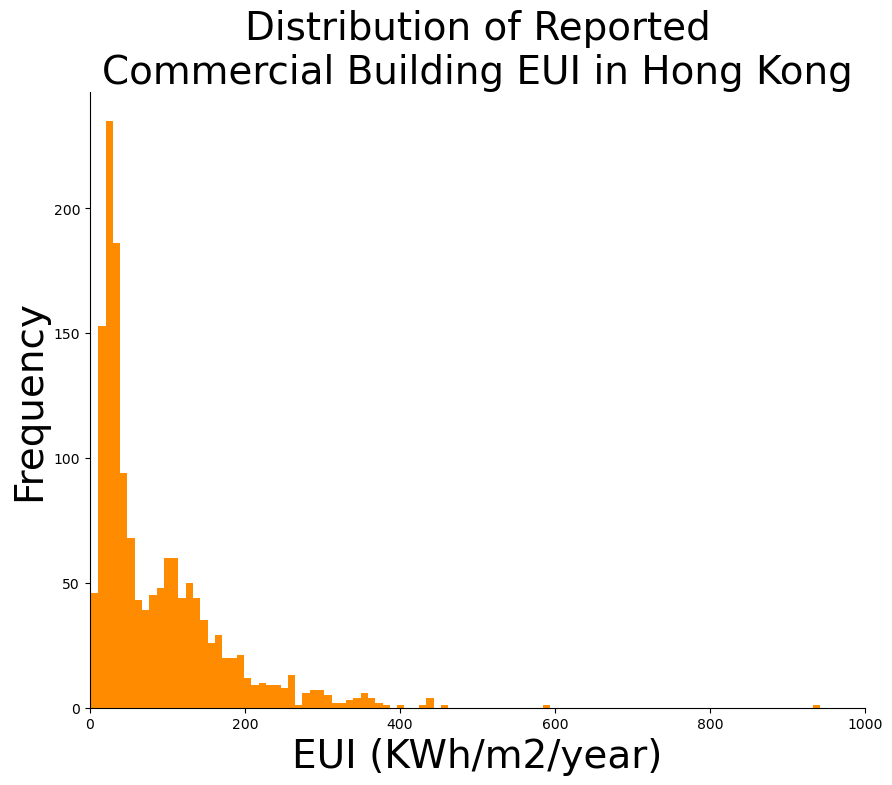

In [18]:
# Building Energy Usage Intensity
y1 = data['bld_eui2']
fig, ax = plt.subplots(figsize=(10,8))

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 28
plt.hist((y1), bins = 100, color = 'darkorange')
plt.ylabel('Frequency',fontsize = 28)
plt.xlabel("EUI (KWh/m2/year)",fontsize = 28)
plt.title("Distribution of Reported\nCommercial Building EUI in Hong Kong",fontsize = 28)
# Hide the right and top spines
ax.set_xlim([0,1000])  # The range of Y axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [19]:
log_eui = np.log10(data['bld_eui2'])
log_eui_median = log_eui.median()

In [20]:
log_eui_median

1.7269715836828767

In [21]:
data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < log_eui_median, "low", "high")

In [22]:
y = data['bld_eui2_label'].reset_index(drop=True)

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['low','high'])
ylabel = le.transform(y)

1.749856622787119 0.4158091866375914


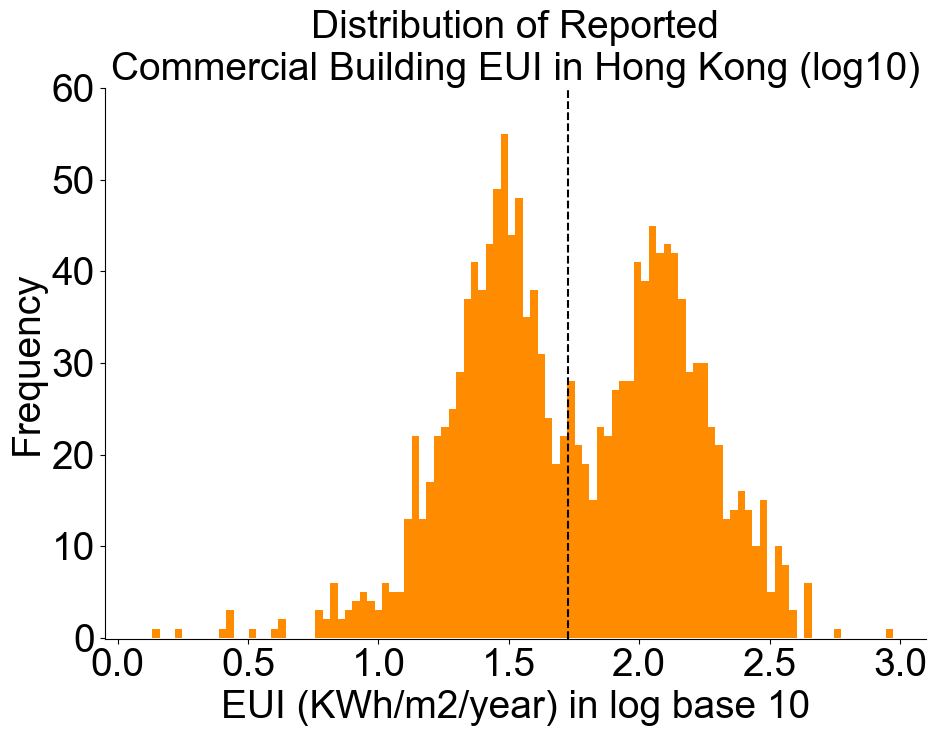

In [26]:
y1 = data['bld_eui2']
mu = np.mean(np.log10(y1))
print(np.mean(np.log10(y1)),np.std(np.log10(y1)))
sigma =np.std(np.log10(y1))
mu,sigma

fig, ax = plt.subplots(figsize=(10,8))

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 28
plt.ylabel('Frequency',fontsize =  28)
plt.xlabel("EUI (KWh/m2/year) in log base 10",fontsize = 28)
plt.title("Distribution of Reported\nCommercial Building EUI in Hong Kong (log10)",fontsize = 28) 
plt.axvline(x = log_eui_median, color='black', linestyle='--') 
plt.hist(np.log10(y1), bins = 100, color = 'darkorange')
plt.subplots_adjust(left=0.25)
ax.set_xlim([-0.05, 3.1])  # The range of X axis
ax.set_ylim([-0.1,60])  # The range of Y axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [27]:
X = data[[
          'log10_footprint', 
          'BS',
          'BH',
          'year_built',
          'reporting_year',
          'log10_hotel', 
          'log10_carparking', 
          'log10_food', 
          'log10_office',
          'log10_retail',
          'CDH',
          'GHI',
          'wind_speed_10m',
          'retro_before_audit', 
          'retro_after_audit',
          'log10_metro_dist',
          'commercial_land_use',
          'individual_AC',
          'central_AC',
          'no_lifts_50%below', 
          'no_lifts_50%_75%', 
          'no_lifts_75%above',
          'operate_start_before8', 
          'operate_start_8_9',
          'operate_start_9_10', 
          'operate_start_after10',
          'operate_hours_25%', 
          'operate_hours_50%', 
          'operate_hours_75%', 
          'operate_hours_100%',
          ]].reset_index(drop=True)
X.to_csv('Sample_dataset_log10.csv',index=False)

In [ ]:
# Full Commercial Building Data Set
data_c = pd.read_csv(
    r"C:\Users\jhcwgtang\Downloads\Full_Commercial-Buildings.csv",
    index_col=0, encoding='utf-8')

In [38]:
# Building Operation Time
data_c['operate_start_before8'] = np.where(data_c['Operate_start_work'] < 8, 1, 0)
data_c['operate_start_8_9'] = np.where(((data_c['Operate_start_work'] >= 8) & (data_c['Operate_start_work'] < 9)), 1, 0)
data_c['operate_start_9_10'] = np.where(((data_c['Operate_start_work'] >= 9) & (data_c['Operate_start_work'] < 10)), 1, 0)
data_c['operate_start_after10'] = np.where(data_c['Operate_start_work'] >= 10, 1, 0)

In [39]:
Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
data['operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                   (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                             (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                                       (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

In [40]:
# Building Retrofitting due to Energy Audit Policy (Before and After)
data_c['retro_before_audit'] = np.where(data_c['retro'] == 'retro_before', 1, 0)  
data_c['retro_after_audit'] = np.where(data_c['retro'] == 'retro_after', 1, 0)  

# Year of Building Construction
data_c.loc[data_c['Year'] < 1950, 'year_built'] = 1
data_c.loc[(data_c['Year'] >= 1950) & (data_c['Year'] < 1960), 'year_built'] = 2
data_c.loc[(data_c['Year'] >= 1960) & (data_c['Year'] < 1970), 'year_built'] = 3
data_c.loc[(data_c['Year'] >= 1970) & (data_c['Year'] < 1980), 'year_built'] = 4
data_c.loc[(data_c['Year'] >= 1980) & (data_c['Year'] < 1990), 'year_built'] = 5
data_c.loc[(data_c['Year'] >= 1990) & (data_c['Year'] < 2000), 'year_built'] = 6
data_c.loc[(data_c['Year'] >= 2000) & (data_c['Year'] < 2010), 'year_built'] = 7
data_c.loc[data_c['Year'] >= 2010, 'year_built'] = 8

# Log10 transformation of Building Footprint
data_c['Area'] = np.where(data_c['highrise'] == 1, data_c['area_upper'], data_c['area_podium'])  
data_c['log10_footprint'] = np.log10(data_c['Area'] + 1)
# Log10 transformation of Kernel Density
data_c['log10_hotel'] = np.log10(data_c['hotel'] + 1)
data_c['log10_retail'] = np.log10(data_c['retail'] + 1)
data_c['log10_carparking'] = np.log10(data_c['parking'] + 1)
data_c['log10_food'] = np.log10(data_c['food'] + 1)
data_c['log10_office'] = np.log10(data_c['office'] + 1)

# Distance to MTR Transit Station
data_c['log10_metro_dist'] = np.log10(data_c['Dist_mtr'])

# Only COMMERCIAL land use is considered (11)
data_c['commercial_land_use'] = np.where(data_c['landuse'] == 11, 1, 0)

# Air condition System  # Haven't mentioned in paper (individual and central)
data_c['individual_AC'] = np.where(data_c['AC_type'] == 'Individual Air-Conditioning System', 1, 0)
data_c['central_AC'] = np.where(data_c['AC_type'] == 'Central Air-Conditioning System', 1, 0)

# Number of Lift in a certain building
data_c['no_lifts'] = data_c['Passage_lift'] + data_c['Service_lift']  
no_lifts_percentile = np.nanpercentile(data_c['no_lifts'], [50, 75]) 
data_c['no_lifts_c'] = np.where(data_c['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data_c['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data_c['no_lifts']), np.NaN, "no_lifts_75%above")))) 

In [41]:
# 50% and 75% and 100%
data_c['no_lifts_50%below'] = np.where(data_c['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
data_c['no_lifts_50%_75%'] = np.where(data_c['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
data_c['no_lifts_75%above'] = np.where(data_c['no_lifts_c'] == 'no_lifts_75%above', 1, 0)

In [42]:
#### Building Operation Time
data_c['operate_start_before8'] = np.where(data_c['Operate_start_work'] < 8, 1, 0)
data_c['operate_start_8_9'] = np.where(((data_c['Operate_start_work'] >= 8) & (data_c['Operate_start_work'] < 9)), 1, 0)
data_c['operate_start_9_10'] = np.where(((data_c['Operate_start_work'] >= 9) & (data_c['Operate_start_work'] < 10)), 1, 0)
data_c['operate_start_after10'] = np.where(data_c['Operate_start_work'] >= 10, 1, 0)

In [43]:
Operate_hours_percentile = np.nanpercentile(data_c['bld_opr_hrs'], [25, 50, 75])
data_c['Operate_hours_c'] = np.where(data_c['bld_opr_hrs'] < Operate_hours_percentile[0], 'Operate_hours_25%',
                                   (np.where(data_c['bld_opr_hrs'] < Operate_hours_percentile[1], 'Operate_hours_50%', 
                                             (np.where(data_c['bld_opr_hrs'] < Operate_hours_percentile[2], 'Operate_hours_75%', 
                                                       (np.where(pd.isna(data_c['bld_opr_hrs']), np.NaN, 'Operate_hours_100%')))))))  

In [44]:
data_c['operate_hours_25%'] = np.where(data_c['Operate_hours_c'] == 'Operate_hours_25%', 1, 0)
data_c['operate_hours_50%'] = np.where(data_c['Operate_hours_c'] == 'Operate_hours_50%', 1, 0)
data_c['operate_hours_75%'] = np.where(data_c['Operate_hours_c'] == 'Operate_hours_75%', 1, 0)
data_c['operate_hours_100%'] = np.where(data_c['Operate_hours_c'] == 'Operate_hours_100%', 1, 0)

In [45]:
Dataset = data_c[[
         'log10_footprint', 
         'BH',
         'year_built',
         'log10_hotel', 
         'log10_carparking', 
         'log10_food',
         'log10_office',
         'log10_retail',
         'wind_speed_10m',
         'GHI',
         'CDH',
         'log10_metro_dist',
         'commercial_land_use',
         'individual_AC',
         'central_AC',
         'no_lifts_50%below', 
         'no_lifts_50%_75%', 
         'no_lifts_75%above',
         'operate_start_before8',
         'operate_start_8_9', 
         'operate_start_9_10',
         'operate_start_after10',
         'operate_hours_25%', 
         'operate_hours_50%', 
         'operate_hours_75%', 
         'operate_hours_100%',
         ]].reset_index(drop=True)
Dataset.to_csv('Citybased_dataset_log10.csv',index=False)

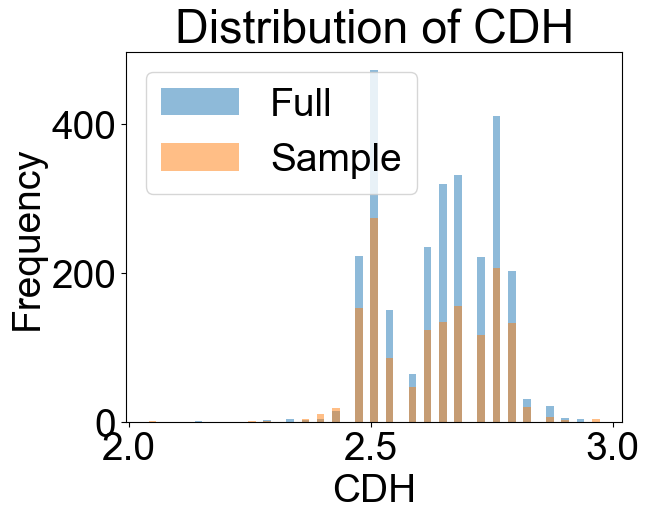

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'CDH'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Calculate the common range for bins
min_value = min(sample_input_feature.min(), full_input_feature.min())
max_value = max(sample_input_feature.max(), full_input_feature.max())

# Define the number of bins for each dataset
num_bins = 59

# Generate the bin edges for both datasets
bins = np.linspace(min_value, max_value, num_bins + 1)

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=bins, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=bins, alpha=0.5, label='Sample')

plt.legend(loc='upper left')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_cdh.png', dpi=300, bbox_inches = 'tight')
plt.show()

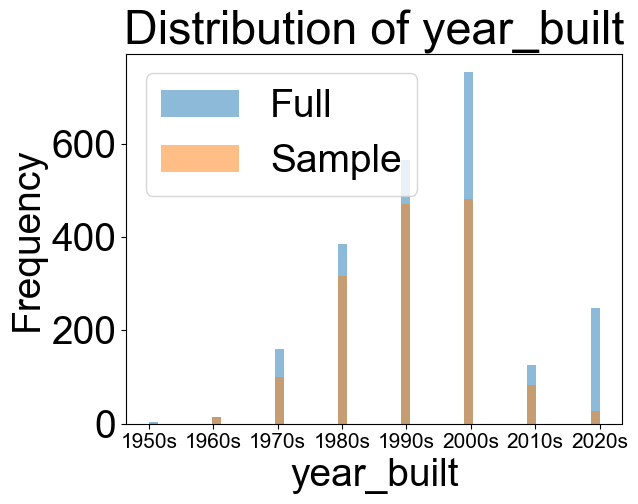

In [375]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'year_built'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, range=(1, 8), alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=50, range=(1, 8), alpha=0.5, label='Sample')

plt.legend(loc='upper left')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')

# Set the x-axis tick labels
tick_labels = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
plt.xticks(range(1, 9), tick_labels, fontsize = 15)  # Set the tick labels

plt.savefig('dis_year_built.png', dpi=300, bbox_inches='tight')
plt.show()

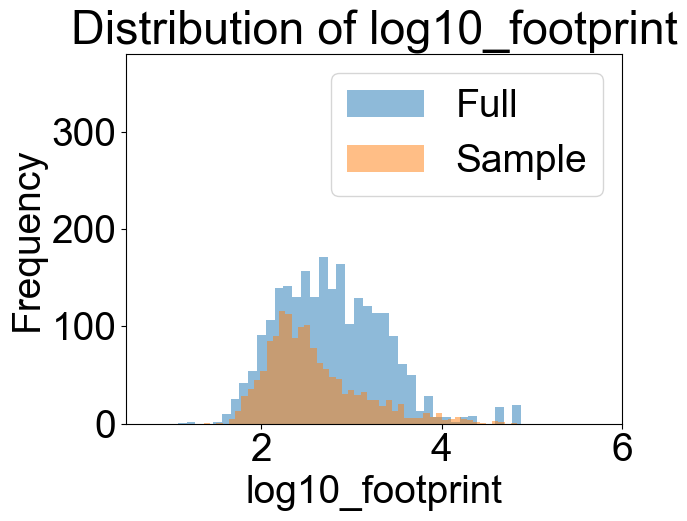

In [376]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_footprint'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=50, alpha=0.5, label='Sample')
plt.xlim([0.5, 6])
plt.ylim([0, 380])
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_log10_footprint.png', dpi=300, bbox_inches='tight')
plt.show()

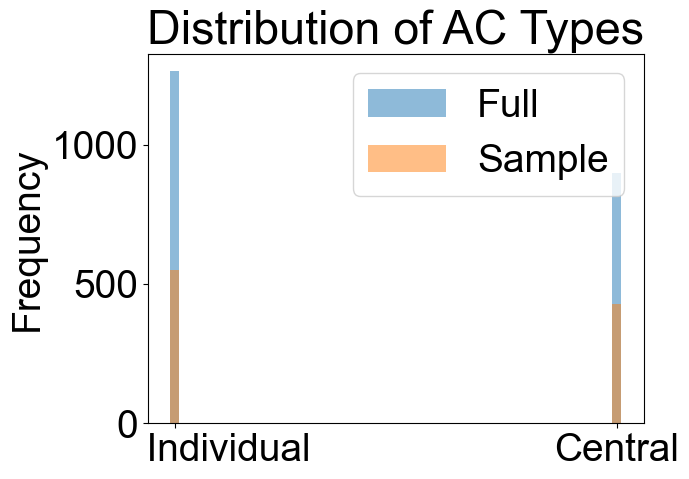

In [377]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input features to compare
individual_ac_feature = 'individual_AC'
central_ac_feature = 'central_AC'

# Extract input features from both datasets
sample_individual_ac = sample_data[individual_ac_feature]
full_individual_ac = full_data[individual_ac_feature]
sample_central_ac = sample_data[central_ac_feature]
full_central_ac = full_data[central_ac_feature]

# Count the occurrences of AC types in the sample dataset
sample_counts = pd.Series([sample_individual_ac.sum(), sample_central_ac.sum()], index=['Individual', 'Central'])

# Count the occurrences of AC types in the full dataset
full_counts = pd.Series([full_individual_ac.sum(), full_central_ac.sum()], index=['Individual', 'Central'])

# Prepare the AC types and corresponding counts for the bar chart
ac_types = ['          Individual', 'Central']
sample_ac_counts = [sample_counts['Individual'], sample_counts['Central']]
full_ac_counts = [full_counts['Individual'], full_counts['Central']]

# Plot the bar chart
x = range(len(ac_types))
width = 0.02
fig, ax = plt.subplots()

rects2 = ax.bar(x, full_ac_counts, width, label='Full', color='#1f77b4',alpha=0.5)
rects1 = ax.bar(x, sample_ac_counts, width, label='Sample', color='#ff7f0e',alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_title('Distribution of AC Types')
ax.set_xticks(x)
ax.set_xticklabels(ac_types)
ax.legend(loc='upper right')
# Adjust the lower limit of the y-axis
plt.savefig('dis_AC_type.png', dpi=300, bbox_inches = 'tight')
plt.show()

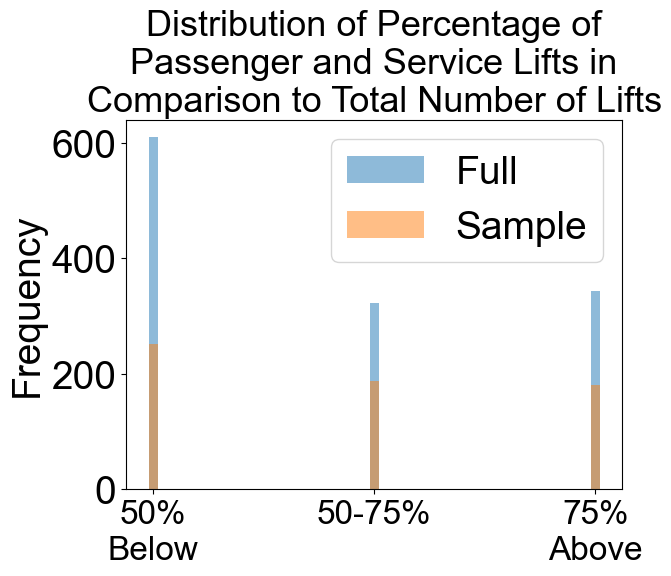

In [378]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input features to compare
no_lifts_50_below_feature = 'no_lifts_50%below'
no_lifts_50_75_feature = 'no_lifts_50%_75%'
no_lifts_75_above_feature = 'no_lifts_75%above'

# Extract input features from both datasets
sample_no_lifts_50_below = sample_data[no_lifts_50_below_feature]
sample_no_lifts_50_75 = sample_data[no_lifts_50_75_feature]
sample_no_lifts_75_above = sample_data[no_lifts_75_above_feature]

full_no_lifts_50_below = full_data[no_lifts_50_below_feature]
full_no_lifts_50_75 = full_data[no_lifts_50_75_feature]
full_no_lifts_75_above = full_data[no_lifts_75_above_feature]

# Prepare the variables and corresponding counts for the bar chart
variables = ['50%\nBelow', '50-75%', '75%\nAbove']
sample_counts = [sample_no_lifts_50_below.sum(), sample_no_lifts_50_75.sum(), sample_no_lifts_75_above.sum()]
full_counts = [full_no_lifts_50_below.sum(), full_no_lifts_50_75.sum(), full_no_lifts_75_above.sum()]

# Plot the bar chart
x = range(len(variables))
width = 0.04

fig, ax = plt.subplots()
rects2 = ax.bar(x, full_counts, width, label='Full', color='#1f77b4',alpha=0.5)
rects1 = ax.bar(x, sample_counts, width, label='Sample', color='#ff7f0e',alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Distribution of Percentage of\nPassenger and Service Lifts in\nComparison to Total Number of Lifts', fontsize=26)
ax.set_xticks(x)
ax.set_xticklabels(variables, fontsize=24)
ax.legend(loc='upper right')
plt.savefig('dis_lift.png', dpi=300, bbox_inches = 'tight')
plt.show()

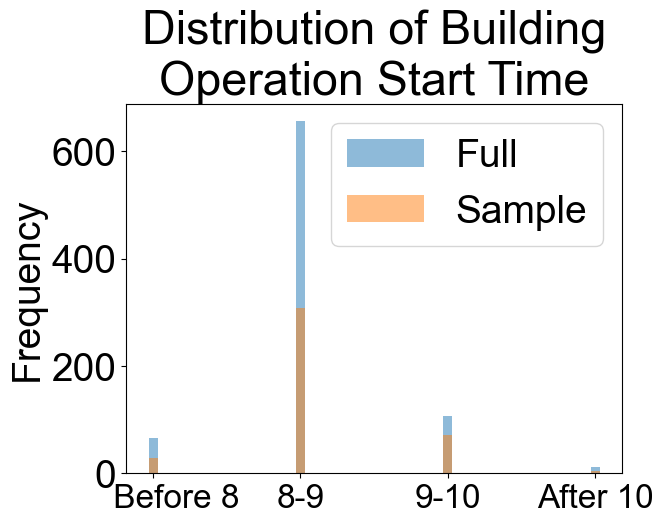

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input features to compare
operate_start_before8_feature = 'operate_start_before8'
operate_start_8_9_feature = 'operate_start_8_9'
operate_start_9_10_feature = 'operate_start_9_10'
operate_start_after10_feature = 'operate_start_after10'

# Extract input features from both datasets
sample_operate_start_before8 = sample_data[operate_start_before8_feature]
sample_operate_start_8_9 = sample_data[operate_start_8_9_feature]
sample_operate_start_9_10 = sample_data[operate_start_9_10_feature]
sample_operate_start_after10 = sample_data[operate_start_after10_feature]

full_operate_start_before8 = full_data[operate_start_before8_feature]
full_operate_start_8_9 = full_data[operate_start_8_9_feature]
full_operate_start_9_10 = full_data[operate_start_9_10_feature]
full_operate_start_after10 = full_data[operate_start_after10_feature]

# Prepare the variables and corresponding counts for the bar chart
variables = ['     Before 8', '8-9', '9-10', 'After 10']
sample_counts = [
    sample_operate_start_before8.sum(),
    sample_operate_start_8_9.sum(),
    sample_operate_start_9_10.sum(),
    sample_operate_start_after10.sum()
]
full_counts = [
    full_operate_start_before8.sum(),
    full_operate_start_8_9.sum(),
    full_operate_start_9_10.sum(),
    full_operate_start_after10.sum()
]

# Plot the bar chart
x = range(len(variables))
width = 0.06
fig, ax = plt.subplots()
rects2 = ax.bar(x, full_counts, width, label='Full', color='#1f77b4', alpha=0.5)
rects1 = ax.bar(x, sample_counts, width, label='Sample', color='#ff7f0e', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Distribution of Building\nOperation Start Time')
ax.set_xticks(x)
ax.set_xticklabels(variables, fontsize=24)
ax.tick_params(axis='y') 
ax.legend(loc='upper right')
plt.savefig('dis_operation_start_time.png', dpi=300, bbox_inches = 'tight')
plt.show()

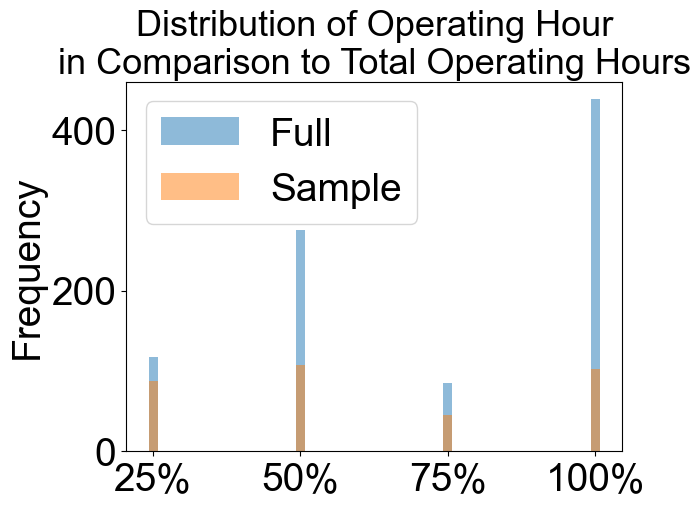

In [328]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input features to compare
operate_hours_25_feature = 'operate_hours_25%'
operate_hours_50_feature = 'operate_hours_50%'
operate_hours_75_feature = 'operate_hours_75%'
operate_hours_100_feature = 'operate_hours_100%'

# Extract input features from both datasets
sample_operate_hours_25 = sample_data[operate_hours_25_feature]
sample_operate_hours_50 = sample_data[operate_hours_50_feature]
sample_operate_hours_75 = sample_data[operate_hours_75_feature]
sample_operate_hours_100 = sample_data[operate_hours_100_feature]

full_operate_hours_25 = full_data[operate_hours_25_feature]
full_operate_hours_50 = full_data[operate_hours_50_feature]
full_operate_hours_75 = full_data[operate_hours_75_feature]
full_operate_hours_100 = full_data[operate_hours_100_feature]

# Prepare the variables and corresponding counts for the bar chart
variables = ['25%', '50%', '75%', '100%']
sample_counts = [
    sample_operate_hours_25.sum(),
    sample_operate_hours_50.sum(),
    sample_operate_hours_75.sum(),
    sample_operate_hours_100.sum()
]
full_counts = [
    full_operate_hours_25.sum(),
    full_operate_hours_50.sum(),
    full_operate_hours_75.sum(),
    full_operate_hours_100.sum()
]

# Plot the bar chart
x = range(len(variables))
width = 0.06

fig, ax = plt.subplots()
rects2 = ax.bar(x, full_counts, width, label='Full', color='#1f77b4', alpha=0.5)
rects1 = ax.bar(x, sample_counts, width, label='Sample', color='#ff7f0e', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Distribution of Operating Hour\nin Comparison to Total Operating Hours', fontsize=26)

ax.set_xticks(x)
ax.set_xticklabels(variables)  # Adjust the font size as needed
ax.legend(loc='upper left')
plt.savefig('dis_operation_hours.png', dpi=300, bbox_inches = 'tight')
plt.show()

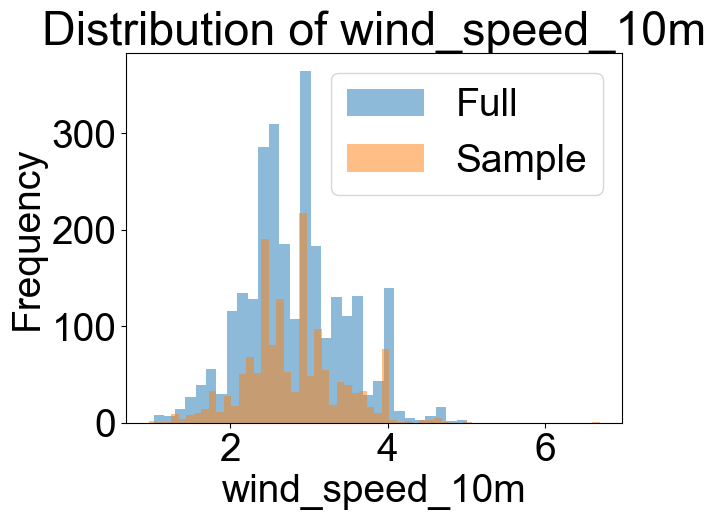

In [281]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'wind_speed_10m'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=30, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=60, alpha=0.5, label='Sample')
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_wind_speed.png', dpi=300, bbox_inches = 'tight')
plt.show()

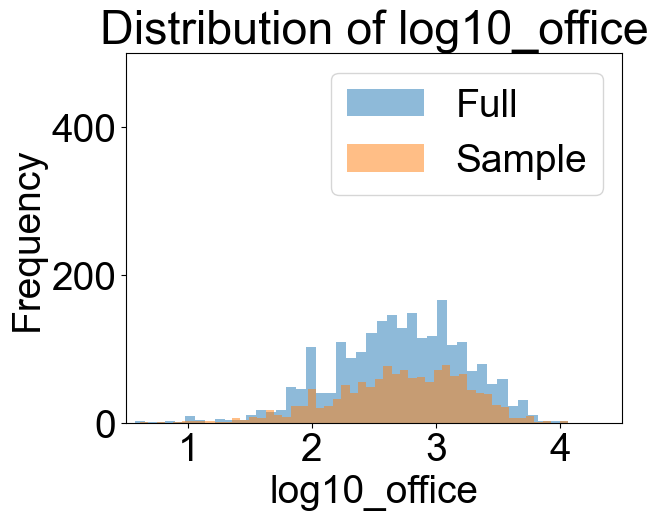

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_office'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=60, alpha=0.5, label='Sample')
plt.xlim([0.5, 4.5])
plt.ylim([0, 500])
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_poi_office.png', dpi=300, bbox_inches = 'tight')
plt.show()

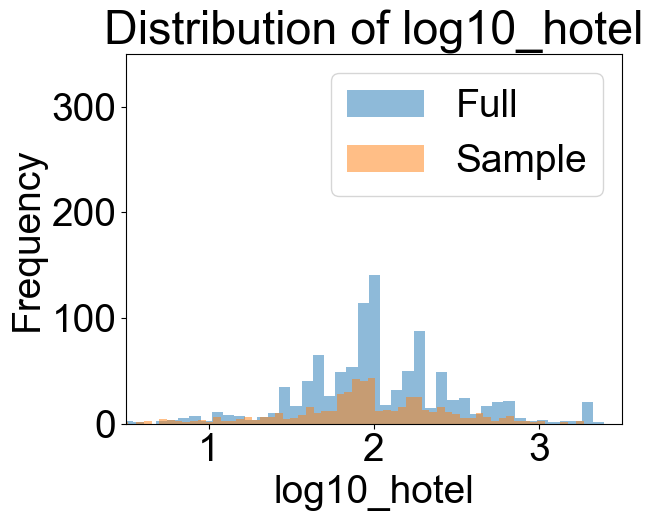

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_hotel'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=70, alpha=0.5, label='Sample')
plt.xlim([0.5, 3.5])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_poi_hotel.png', dpi=300, bbox_inches = 'tight')
plt.show()

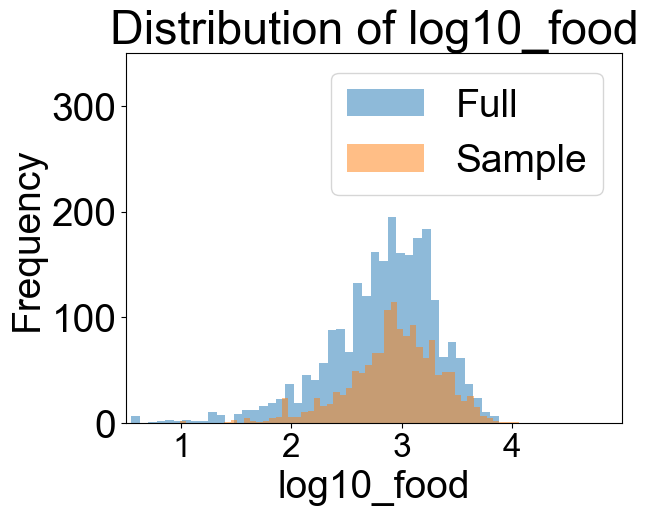

In [279]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_food'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=70, alpha=0.5, label='Sample')
plt.xlim([0.5, 5])
plt.ylim([0, 350])
x = [1,2,3,4]
label = ['1','2','3','4']
plt.xticks(x,label,fontsize=24)
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_poi_food.png', dpi=300, bbox_inches = 'tight')
plt.show()

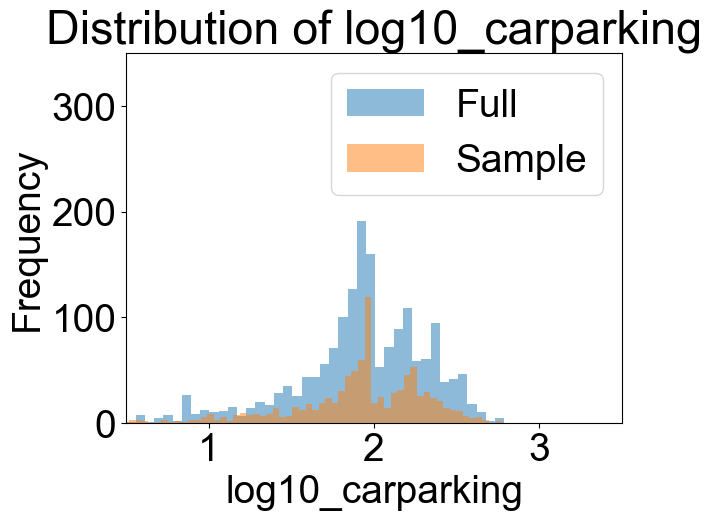

In [249]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_carparking'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=70, alpha=0.5, label='Sample')
plt.xlim([0.5, 3.5])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_poi_parking.png', dpi=300, bbox_inches = 'tight')
plt.show()

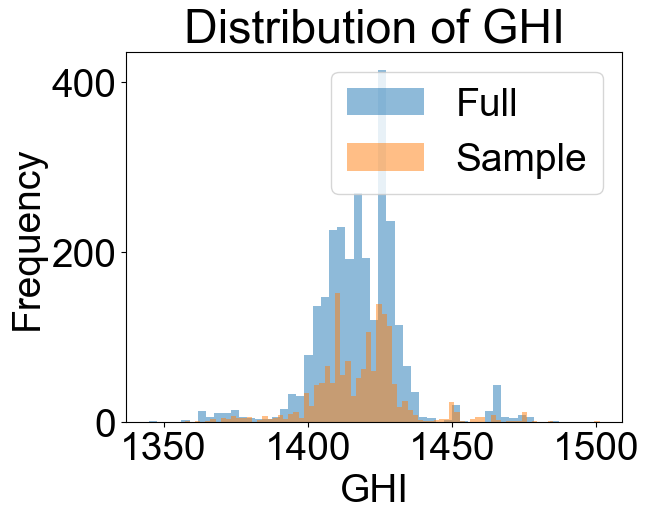

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'GHI'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=80, alpha=0.5, label='Sample')
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_ghi.png', dpi=300, bbox_inches = 'tight')
plt.show()

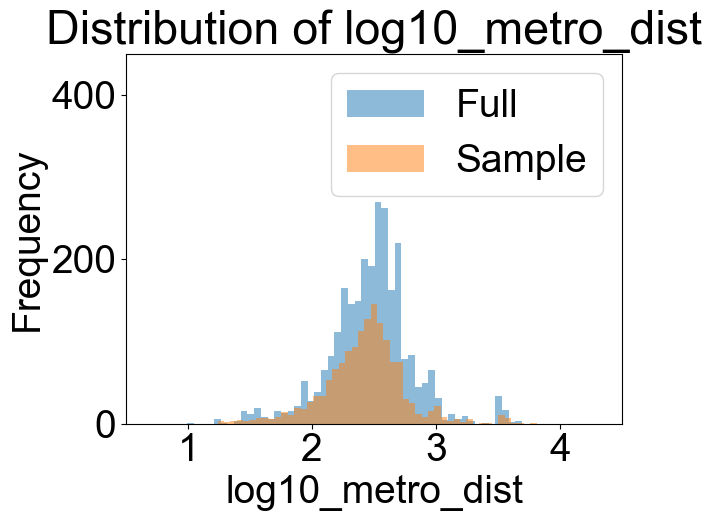

In [329]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_metro_dist'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=50, alpha=0.5, label='Sample')
plt.xlim([0.5, 4.5])
plt.ylim([0, 450])
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_metro_dist.png', dpi=300, bbox_inches = 'tight')
plt.show()

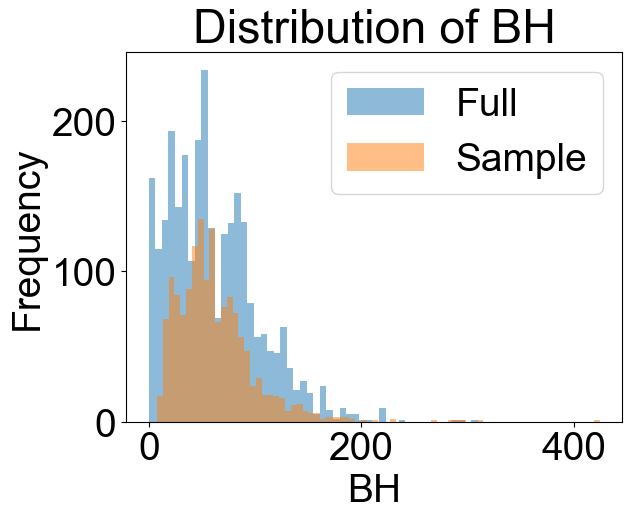

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'BH'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=76, alpha=0.5, label='Sample')
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_BH.png', dpi=300, bbox_inches='tight')
plt.show()

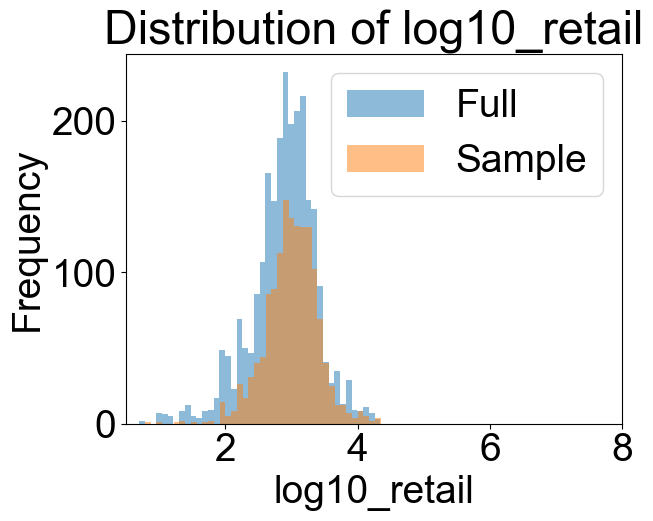

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'log10_retail'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=50, alpha=0.5, label='Sample')
plt.legend(loc='upper right')
plt.title('Distribution of ' + input_feature)
plt.xlim([0.5, 8])
plt.xlabel(input_feature)
plt.ylabel('Frequency')
plt.savefig('dis_poi_retail.png', dpi=300, bbox_inches = 'tight')
plt.show()

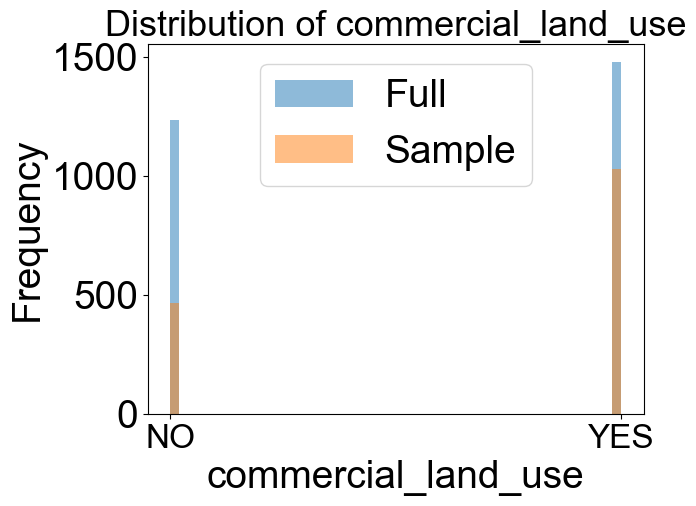

In [333]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sample and full datasets from CSV files
sample_data = pd.read_csv('Sample_dataset_log10.csv')
full_data = pd.read_csv('Citybased_dataset_log10.csv')

# Select input feature to compare
input_feature = 'commercial_land_use'

# Extract input feature from both datasets
sample_input_feature = sample_data[input_feature]
full_input_feature = full_data[input_feature]

# Plot histograms for both datasets
plt.hist(full_input_feature, bins=50, alpha=0.5, label='Full')
plt.hist(sample_input_feature, bins=50, alpha=0.5, label='Sample')
plt.legend(loc='upper center')
plt.title('Distribution of ' + input_feature, fontsize=26)
plt.xlabel(input_feature)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=24)
plt.ylabel('Frequency')
plt.savefig('dis_commercial_land_use.png', dpi=300, bbox_inches = 'tight')
plt.show()


In [38]:
y

0        low
1        low
2        low
3        low
4        low
        ... 
1490    high
1491    high
1492    high
1493    high
1494    high
Name: bld_eui2_label, Length: 1495, dtype: object

In [523]:
# Random Forest
import numpy as np
seed = 8000
rf = RandomForestClassifier(random_state=seed)

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=50)]
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(3, 10, num=20)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14, 16, 18, 20, 30]
min_samples_leaf = [4, 6, 8]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

parameter_dis = {'n_estimators': n_estimators,  # number of trees in the forest
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'criterion': criterion}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=parameter_dis,
                               n_iter=200, cv=5, verbose=1, n_jobs=-1, scoring='accuracy', refit=False)
rf_random.fit(X, y)

# Selecting the best parameter
best_params_ = rf_random.best_params_

# Random Forest Classification
rf = RandomForestClassifier(random_state=seed,
                            n_estimators=best_params_['n_estimators'],
                            min_samples_split=best_params_['min_samples_split'],
                            min_samples_leaf=best_params_['min_samples_leaf'],
                            max_features=best_params_['max_features'],
                            max_depth=best_params_['max_depth'],
                            bootstrap=best_params_['bootstrap'],
                            criterion=best_params_['criterion'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print("--------------------------------- Random Forest Result ----------------------------------------")
    print(rf.score(X.iloc[test], y.iloc[test]))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
              precision    recall  f1-score   support

        high     0.7752    0.7194    0.7463       139
         low     0.7706    0.8187    0.7939       160

    accuracy                         0.7726       299
   macro avg     0.7729    0.7691    0.7701       299
weighted avg     0.7727    0.7726    0.7718       299

--------------------------------- Random Forest Result ----------------------------------------
0.7725752508361204
              precision    recall  f1-score   support

        high     0.8710    0.7152    0.7855       151
         low     0.7543    0.8919    0.8173       148

    accuracy                         0.8027       299
   macro avg     0.8126    0.8036    0.8014       299
weighted avg     0.8132    0.8027    0.8012       299

--------------------------------- Random Forest Result ----------------------------------------
0.802675585284281
              precision    recall  f1-score   support

In [36]:
prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction.csv')
test = pd.DataFrame(test, columns=['test']).to_csv('test.csv')

In [ ]:
df_fill = pd.read_csv('Citybased_dataset_log10.csv')
df_fill.head()

In [ ]:
ya = rf.predict(df_fill)
print(pd.DataFrame(ya,columns=['eui']))

results = pd.DataFrame(ya)
data_filled = df_fill.join(results)
data_filled.to_csv('RF_prediction.csv')

In [ ]:
ya = rf.predict(df_fill)
print(pd.DataFrame(ya,columns=['eui']))

results = pd.DataFrame(ya)
data_filled = df_fill.join(results)
data_filled.to_csv('RF_prediction.csv')

In [50]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics

seed = 8000
rf = RandomForestRegressor(random_state=seed)

max_features = ['sqrt']
max_depth = [10]
max_depth.append(None)
min_samples_split = [12]
min_samples_leaf = [4]
bootstrap = [True]
criterion = ['mse', 'mae']

parameter_dis = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion
}

n_iter = 10

# Create an instance of RandomizedSearchCV and fit it to the data
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=seed),
    param_distributions=parameter_dis,
    n_iter=n_iter,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    refit=False
)
rf_random.fit(X, log_eui)

# Retrieve the best parameters
best_params_ = rf_random.best_params_

# Create an instance of RandomForestRegressor using the best parameters
rf = RandomForestRegressor(random_state=seed, **best_params_)

# Perform cross-validation and print the results
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, log_eui), range(5)):
    rf.fit(X.iloc[train], log_eui.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    mse = metrics.mean_squared_error(log_eui.iloc[test], y_pred)
    r2 = metrics.r2_score(log_eui.iloc[test], y_pred)
    accuracy = rf.score(X.iloc[test], log_eui.iloc[test]) * 100
    
    print("--------------------------------- Random Forest Result ----------------------------------------")
    print("Mean Squared Error:", mse)
    print("R2 Score:", r2)
    print("Accuracy (%):", accuracy)

C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


--------------------------------- Random Forest Result ----------------------------------------
Mean Squared Error: 0.09160204764563344
R2 Score: 0.3872693738681975
Accuracy (%): 38.72693738681975


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


--------------------------------- Random Forest Result ----------------------------------------
Mean Squared Error: 0.10488457786716572
R2 Score: 0.4067934575009552
Accuracy (%): 40.67934575009552


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


--------------------------------- Random Forest Result ----------------------------------------
Mean Squared Error: 0.12497504496303134
R2 Score: 0.3496644323181777
Accuracy (%): 34.96644323181777


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


--------------------------------- Random Forest Result ----------------------------------------
Mean Squared Error: 0.12283715738722077
R2 Score: 0.3302643322988552
Accuracy (%): 33.02643322988552


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


--------------------------------- Random Forest Result ----------------------------------------
Mean Squared Error: 0.10545971490419428
R2 Score: 0.345831743256409
Accuracy (%): 34.5831743256409


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.

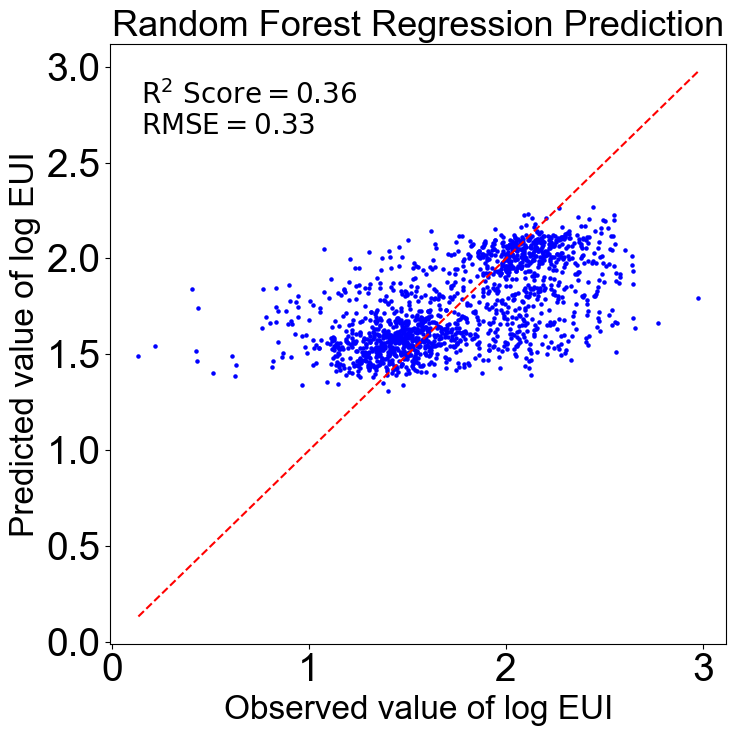

In [51]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn import metrics

# Perform cross-validation and calculate mean predicted values
plt.rcParams["font.family"] = "arial"
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
y_test_all = []
y_pred_all = []
mse_scores = []
r2_scores = []
for (train, test), i in zip(cv.split(X, log_eui), range(5)):
    rf.fit(X.iloc[train], log_eui.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    
    y_test_all.extend(log_eui.iloc[test])
    y_pred_all.extend(y_pred)
    
    # Calculate MSE, RMSE, and R2 score
    mse = metrics.mean_squared_error(log_eui.iloc[test], y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(log_eui.iloc[test], y_pred)
    mse_scores.append(rmse)
    r2_scores.append(r2)

# Convert the lists to NumPy arrays
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

# Set the font to Arial
font_path = r"C:\Users\jhcwgtang\Downloads\Arial.ttf"   # Path to Arial font file
font_prop = font_manager.FontProperties(fname=font_path)

# Create a scatter plot of the mean predicted values versus the actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_all, y_pred_all, color='b', alpha=1, s=5, label='Data')
plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], 'r--')
plt.xlabel('Observed value of log EUI', fontproperties=font_prop, fontsize=24)
plt.ylabel('Predicted value of log EUI', fontproperties=font_prop, fontsize=24)
plt.title('Random Forest Regression Prediction', fontproperties=font_prop, fontsize=26)

# Add text labels for R2 score and RMSE
textstr = '\n'.join((
    r'$\mathrm{R^2\ Score}=%.2f$' % (np.mean(r2_scores),),
    r'$\mathrm{RMSE}=%.2f$' % (np.mean(mse_scores),)))
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,
         fontsize=20, verticalalignment='baseline', fontproperties=font_prop)

plt.tight_layout()
plt.show()

In [49]:
# XGBoost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

data_matrix = xgb.DMatrix(data=X, label=ylabel)

# set the prarameter 
space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
         'learning_rate': hp.uniform("learning_rate", 0.05, 0.3),
         'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
         'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
         'reg_alpha': hp.quniform("reg_alpha", 0, 100, 1),
         'reg_lambda': hp.uniform("reg_lambda", 0, 2),
         'subsample': hp.uniform("subsample", 0.5, 1),
         'min_split_loss': hp.uniform("min_split_loss", 0, 9),
         'rate_drop': hp.uniform("rate_drop", 0, 1)}


def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'],
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'],
                          'booster': 'gbtree',
                          # 'rate_drop': space['rate_drop'],
                          'objective': 'binary:logistic'}
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round=200, seed=8000, metrics='error')

    return {"loss": (xgb_cv_result["test-error-mean"]).tail(1).iloc[0], "status": STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

param_dict_tunning = {'objective': 'binary:logistic', 'eval_metric': 'error',
                      'max_depth': int(best_hyperparams['max_depth']),
                      'reg_alpha': best_hyperparams['reg_alpha'], 'reg_lambda': best_hyperparams['reg_lambda'],
                      'min_child_weight': best_hyperparams['min_child_weight'],
                      'colsample_bytree': best_hyperparams['colsample_bytree'],
                      'learning_rate': best_hyperparams['learning_rate'], 'subsample': best_hyperparams['subsample'],
                      'min_split_loss': best_hyperparams['min_split_loss'],
                      # 'rate_drop':best_hyperparams['rate_drop'],
                      'booster': 'gbtree'}

for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, ylabel):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=ylabel[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=ylabel[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]

    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                          xgb_model=None, verbose_eval=False, early_stopping_rounds=30)

    y_pred_pro = xgb_model.predict(test_matrix)
    y_pred = [round(value) for value in y_pred_pro]
    y_true = ylabel[test]
    print("----------------------------------------- XGBoost Result -------------------------------------------------")
    print(metrics.classification_report(y_true, y_pred, digits=4))

C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


  0%|▏                                              | 1/200 [00:00<00:28,  7.10trial/s, best loss: 0.24347839999999996]

C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


100%|█████████████████████████████████████████████| 200/200 [00:51<00:00,  3.90trial/s, best loss: 0.21337780000000003]
----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7410    0.7410    0.7410       139
           1     0.7750    0.7750    0.7750       160

    accuracy                         0.7592       299
   macro avg     0.7580    0.7580    0.7580       299
weighted avg     0.7592    0.7592    0.7592       299



C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pa

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8060    0.7152    0.7579       151
           1     0.7394    0.8243    0.7796       148

    accuracy                         0.7692       299
   macro avg     0.7727    0.7698    0.7687       299
weighted avg     0.7730    0.7692    0.7686       299

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7582    0.7436    0.7508       156
           1     0.7260    0.7413    0.7336       143

    accuracy                         0.7425       299
   macro avg     0.7421    0.7424    0.7422       299
weighted avg     0.7428    0.7425    0.7426       299



C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pa

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7612    0.6939    0.7260       147
           1     0.7273    0.7895    0.7571       152

    accuracy                         0.7425       299
   macro avg     0.7442    0.7417    0.7415       299
weighted avg     0.7439    0.7425    0.7418       299

----------------------------------------- XGBoost Result -------------------------------------------------


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0     0.7698    0.6903    0.7279       155
           1     0.7000    0.7778    0.7368       144

    accuracy                         0.7324       299
   macro avg     0.7349    0.7341    0.7324       299
weighted avg     0.7362    0.7324    0.7322       299



In [ ]:
prediction_xgb = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_xgb.csv')
test_xgb = pd.DataFrame(test, columns=['test']).to_csv('test_xgb.csv')
lable_xgb = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_xgb.csv')

In [ ]:
df_fill_2 = pd.read_csv('Citybased_dataset.csv')
df_fill_2.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [ ]:
data_fill_2 = xgb.DMatrix(data=df_fill_2)
ya_2 = xgb_model.predict(data_fill_2)
print(pd.DataFrame(ya_2,columns=['eui']))

results_2 = pd.DataFrame(ya_2)
data_filled2 = df_fill.join(results_2)

data_filled2.to_csv('XGBoost_prediction.csv')

--------------------------------- XGBoost Regression Result ----------------------------------------
R-squared: 0.33596977461042554
RMSE: 0.3150733864691797


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


--------------------------------- XGBoost Regression Result ----------------------------------------
R-squared: 0.36030175788935115
RMSE: 0.3363105024276711


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


--------------------------------- XGBoost Regression Result ----------------------------------------
R-squared: 0.34734621914190866
RMSE: 0.35414761921993687


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


--------------------------------- XGBoost Regression Result ----------------------------------------
R-squared: 0.32333871174441753
RMSE: 0.35228879510813704


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


--------------------------------- XGBoost Regression Result ----------------------------------------
R-squared: 0.289881961916597
RMSE: 0.33834817286960067


C:\Users\jhcwgtang\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


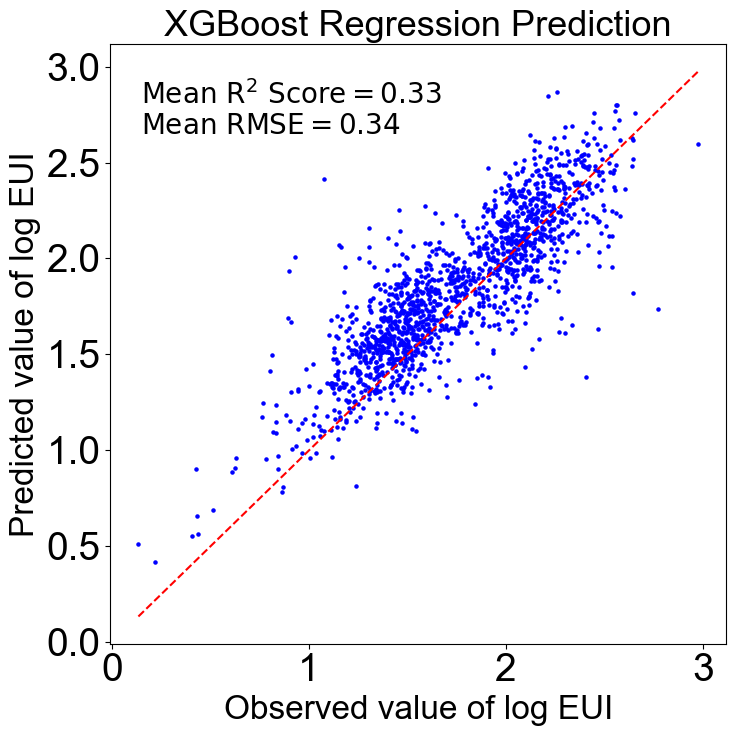

In [53]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Assuming you have your input features stored in the 'X' DataFrame and labels in the 'log_eui' variable as a NumPy array

param_dict_tuning = {
    'objective': 'reg:squarederror',
    'eta': 0.02,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'nthread': 4,
    'seed': 8000
}

kf = KFold(n_splits=5, shuffle=True, random_state=8000)  # Create KFold instance

r2_scores = []
rmse_scores = []

X_reset = X.reset_index(drop=True)  # Reset the index of X
log_eui_reset = pd.Series(log_eui).reset_index(drop=True)  # Reset the index of log_eui

for train_indices, test_indices in kf.split(X_reset):
    train_indices = list(train_indices)  # Convert train_indices to a list
    test_indices = list(test_indices)  # Convert test_indices to a list

    input_matrix = xgb.DMatrix(data=X_reset.iloc[train_indices], label=log_eui_reset.iloc[train_indices])
    test_matrix = xgb.DMatrix(data=X_reset.iloc[test_indices], label=log_eui_reset.iloc[test_indices])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]

    xgb_model = xgb.train(params=param_dict_tuning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                          xgb_model=None, verbose_eval=False, early_stopping_rounds=30)

    y_pred = xgb_model.predict(test_matrix)
    y_true = log_eui_reset.iloc[test_indices]

    r2 = metrics.r2_score(y_true, y_pred)
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    print("--------------------------------- XGBoost Regression Result ----------------------------------------")
    print("R-squared:", r2)
    print("RMSE:", rmse)

# Set the font to Arial
font_path = r"C:\Users\jhcwgtang\Downloads\Arial.ttf"  # Path to Arial font file
font_prop = font_manager.FontProperties(fname=font_path)

# Set the font properties for the plot
plt.rcParams['font.family'] = font_prop.get_name()

# Create a scatter plot of the mean predicted values plus noise versus the actual values
plt.figure(figsize=(8, 8))
plt.scatter(log_eui_reset, xgb_model.predict(xgb.DMatrix(X_reset)), color='b', alpha=1, s=5, label='Data')
plt.plot([min(log_eui_reset), max(log_eui_reset)], [min(log_eui_reset), max(log_eui_reset)], 'r--')
plt.xlabel('Observed value of log EUI',fontproperties=font_prop, fontsize=24)
plt.ylabel('Predicted value of log EUI', fontproperties=font_prop,fontsize=24)
plt.title('XGBoost Regression Prediction',fontproperties=font_prop, fontsize=26)

# Add text labels for R2 score and RMSE
textstr = '\n'.join((
    r'$\mathrm{Mean\ R^2\ Score}=%.2f$' % (np.mean(r2_scores),),
    r'$\mathrm{Mean\ RMSE}=%.2f$' % (np.mean(rmse_scores),)))
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,fontproperties=font_prop,
         fontsize=20, verticalalignment='baseline')

plt.tight_layout()
plt.show()

In [195]:
# Deep learning
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import wrapt

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

model = Sequential()
model.add(Dense(24, input_dim=len(X.iloc[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    model.fit(X_normalized[train], ylabel[train], epochs=150, batch_size=1024, verbose=0)

    y_pred_pro = model.predict(X_normalized[test], batch_size=1024, verbose=0)
    y_pred = np.round(y_pred_pro)
    print("----------------------------------- Deep Learning Result -------------------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7807    0.6403    0.7036       139
           1     0.7297    0.8438    0.7826       160

    accuracy                         0.7492       299
   macro avg     0.7552    0.7420    0.7431       299
weighted avg     0.7534    0.7492    0.7459       299

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8099    0.6490    0.7206       151
           1     0.7022    0.8446    0.7669       148

    accuracy                         0.7458       299
   macro avg     0.7561    0.7468    0.7437       299
weighted avg     0.7566    0.7458    0.7435       299

----------------------------------- Deep Learning Result -------------------------------------------------
              precision  

In [ ]:
prediction_dp = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_dp.csv')
test_dp = pd.DataFrame(test).to_csv('test_dp.csv')
lable_dp = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_dp.csv')

In [ ]:
df_fill_3 = pd.read_csv('Citybased_dataset.csv')
df_fill_3.head()

In [ ]:
X_normalized_dp = input_scaler.transform(df_fill_3)

ya_3 = model.predict(df_fill_3, batch_size=1024, verbose=0)
print(pd.DataFrame(ya_3,columns=['eui']))

results_3 = pd.DataFrame(ya_3)
data_filled_3 = df_fill.join(results_3)
data_filled_3.to_csv('DeepLearning_prediction.csv')

10/10 [==============================] - 0s 2ms/step
----------------------------------- Deep Learning Result -------------------------------------------------
R2 Score: 0.1688755016517508
RMSE: 0.3524932774044401
10/10 [==============================] - 0s 2ms/step
----------------------------------- Deep Learning Result -------------------------------------------------
R2 Score: 0.33413918997607794
RMSE: 0.34311885073205906
10/10 [==============================] - 0s 890us/step
----------------------------------- Deep Learning Result -------------------------------------------------
R2 Score: 0.34304276711204795
RMSE: 0.35531328565876696
10/10 [==============================] - 0s 688us/step
----------------------------------- Deep Learning Result -------------------------------------------------
R2 Score: 0.2857413547737697
RMSE: 0.36194361313612844
10/10 [==============================] - 0s 2ms/step
----------------------------------- Deep Learning Result -------------------------

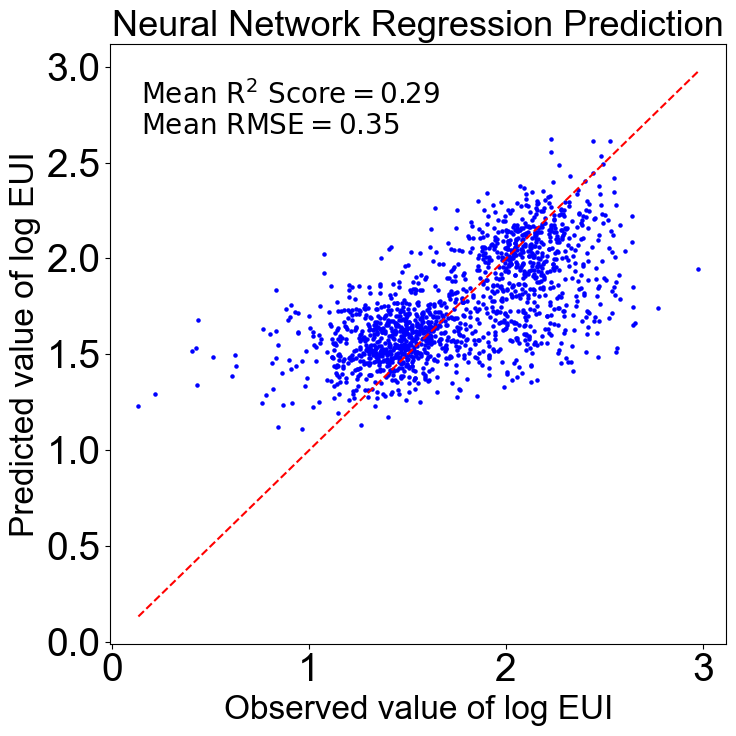

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

model = Sequential()
model.add(Dense(24, input_dim=len(X.iloc[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
r2_scores = []
rmse_scores = []

X_normalized = np.array(X_normalized)  # Convert to NumPy array
log_eui = np.array(log_eui)  # Convert to NumPy array

for (train, test), i in zip(cv.split(X_normalized, log_eui), range(5)):
    model.fit(X_normalized[train], log_eui[train], epochs=150, batch_size=1024, verbose=0)

    y_pred = model.predict(X_normalized[test])

    # Calculating R2 score
    r2 = r2_score(log_eui[test], y_pred)
    r2_scores.append(r2)

    # Calculating RMSE score
    rmse = mean_squared_error(log_eui[test], y_pred, squared=False)
    rmse_scores.append(rmse)

    print("----------------------------------- Deep Learning Result -------------------------------------------------")
    print("R2 Score:", r2)
    print("RMSE:", rmse)

# Set the font to Arial
font_path = r"C:\Users\jhcwgtang\Downloads\Arial.ttf"   # Path to Arial font file
font_prop = font_manager.FontProperties(fname=font_path)

# Set the font properties for the plot
plt.rcParams['font.family'] = font_prop.get_name()

# Create a scatter plot of the mean predicted values versus the actual values
plt.figure(figsize=(8, 8))
plt.scatter(log_eui, model.predict(X_normalized), color='b', alpha=1, s=5, label='Data')
plt.plot([min(log_eui), max(log_eui)], [min(log_eui), max(log_eui)], 'r--')
plt.xlabel('Observed value of log EUI', fontsize=24)
plt.ylabel('Predicted value of log EUI',  fontproperties=font_prop, fontsize=24)
plt.title('Neural Network Regression Prediction',  fontproperties=font_prop,fontsize=26)

# Add text labels for R2 score and RMSE
textstr = '\n'.join((
    r'$\mathrm{Mean\ R^2\ Score}=%.2f$' % (np.mean(r2_scores),),
    r'$\mathrm{Mean\ RMSE}=%.2f$' % (np.mean(rmse_scores),)))
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,
         fontsize=20, fontproperties=font_prop, verticalalignment='baseline')

plt.tight_layout()
plt.show()

In [391]:
# Support vector machine

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

param_SVC = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

SVC_grid = GridSearchCV(SVC(), param_SVC, refit=False, verbose=0, cv=5, scoring='accuracy')
SVC_grid.fit(X_normalized, ylabel)

SVC_model = SVC(**SVC_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    SVC_model.fit(X_normalized[train], y[train])

    y_pred = SVC_model.predict(X_normalized[test])
    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print(metrics.classification_report(y[test], y_pred, digits=4))

    print(SVC_model.score(X_normalized[test], y[test]))

--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.7981    0.5971    0.6831       139
         low     0.7128    0.8688    0.7831       160

    accuracy                         0.7425       299
   macro avg     0.7554    0.7329    0.7331       299
weighted avg     0.7525    0.7425    0.7366       299

0.7424749163879598
--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8716    0.6291    0.7308       151
         low     0.7053    0.9054    0.7929       148

    accuracy                         0.7659       299
   macro avg     0.7884    0.7673    0.7618       299
weighted avg     0.7892    0.7659    0.7615       299

0.7658862876254181
--------------------------------------------- SVM Result -------------------------------------

In [ ]:
df_fill_4 = pd.read_csv('Citybased_dataset.csv')
df_fill_4.head()

In [ ]:
ya_4 = SVC_model.predict(df_fill_4)
print(pd.DataFrame(ya_4,columns=['eui']))

results_4 = pd.DataFrame(ya_4)
data_filled4 = df_fill.join(results_4)
data_filled4.to_csv('SVM_prediction.csv')

In [57]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

SVR_model = SVR()

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
r2_scores = []
rmse_scores = []

for (train, test), i in zip(cv.split(X_normalized, log_eui), range(5)):
    SVR_model.fit(X_normalized[train], log_eui[train])

    y_pred = SVR_model.predict(X_normalized[test])
    r2 = r2_score(log_eui[test], y_pred)
    rmse = mean_squared_error(log_eui[test], y_pred, squared=False)

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print("R2 Score:", r2)
    print("RMSE:", rmse)

# Plot the R2 and RMSE scores
plt.figure(figsize=(8, 6))

--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.27205718527754674
RMSE: 0.32988793215721035
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.3810290734795688
RMSE: 0.33081711993127666
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.3121540979186903
RMSE: 0.36357036364792866
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.23455697173357326
RMSE: 0.3746878414276821
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.2963603641811998
RMSE: 0.33680126257737686


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.27205718527754674
RMSE: 0.32988793215721035
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.3810290734795688
RMSE: 0.33081711993127666
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.3121540979186903
RMSE: 0.36357036364792866
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.23455697173357326
RMSE: 0.3746878414276821
--------------------------------------------- SVM Result -------------------------------------------------
R2 Score: 0.2963603641811998
RMSE: 0.33680126257737686


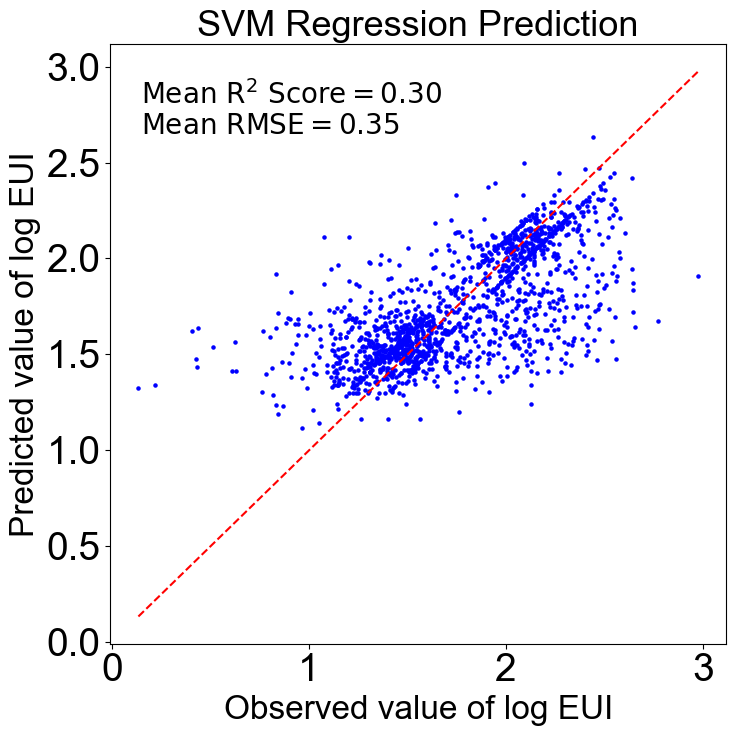

In [58]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import font_manager

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

SVR_model = SVR()

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
r2_scores = []
rmse_scores = []

for (train, test), i in zip(cv.split(X_normalized, log_eui), range(5)):
    SVR_model.fit(X_normalized[train], log_eui[train])

    y_pred = SVR_model.predict(X_normalized[test])
    r2 = r2_score(log_eui[test], y_pred)
    rmse = mean_squared_error(log_eui[test], y_pred, squared=False)

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print("R2 Score:", r2)
    print("RMSE:", rmse)

# Set the font to Arial
font_path = r"C:\Users\jhcwgtang\Downloads\Arial.ttf"   # Path to Arial font file
font_prop = font_manager.FontProperties(fname=font_path)

# Set the font properties for the plot
plt.rcParams['font.family'] = font_prop.get_name()

# Create a scatter plot of the mean predicted values versus the actual values
plt.figure(figsize=(8, 8))
plt.scatter(log_eui, SVR_model.predict(X_normalized), color='b', alpha=1, s=5, label='Data')
plt.plot([min(log_eui), max(log_eui)], [min(log_eui), max(log_eui)], 'r--')
plt.xlabel('Observed value of log EUI', fontproperties=font_prop, fontsize=24)
plt.ylabel('Predicted value of log EUI',fontproperties=font_prop, fontsize=24)
plt.title('SVM Regression Prediction',fontproperties=font_prop, fontsize=26)

# Add text labels for R2 score and RMSE
textstr = '\n'.join((
    r'$\mathrm{Mean\ R^2\ Score}=%.2f$' % (np.mean(r2_scores),),
    r'$\mathrm{Mean\ RMSE}=%.2f$' % (np.mean(rmse_scores),)))
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,
         fontsize=20,fontproperties=font_prop, verticalalignment='baseline')

plt.tight_layout()
plt.show()

In [197]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

NB_grid = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=5, verbose=0, scoring='accuracy')
NB_grid.fit(X, ylabel)

NB_model = GaussianNB(**NB_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    NB_model.fit(X.iloc[train], y[train])
    y_pred = NB_model.predict(X.iloc[test])
    print("------------------------------------- Native Bayes Result -------------------------------------------------")
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print(NB_model.score(X.iloc[test], y[test]))

------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8229    0.5683    0.6723       139
         low     0.7044    0.8938    0.7879       160

    accuracy                         0.7425       299
   macro avg     0.7637    0.7310    0.7301       299
weighted avg     0.7595    0.7425    0.7342       299

0.7424749163879598
------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8879    0.6291    0.7364       151
         low     0.7083    0.9189    0.8000       148

    accuracy                         0.7726       299
   macro avg     0.7981    0.7740    0.7682       299
weighted avg     0.7990    0.7726    0.7679       299

0.7725752508361204
------------------------------------- Native Bayes Result ----------------------------------

In [ ]:
df_fill_5 = pd.read_csv('Citybased_dataset.csv')
df_fill_5.head()

In [ ]:
ya_5 = NB_model.predict(df_fill_5)
print(pd.DataFrame(ya_5,columns=['eui']))

results_5 = pd.DataFrame(ya_5)
data_filled5 = df_fill.join(results_5)
data_filled5.to_csv('NB_prediction.csv')

In [ ]:
df_fill_6 = pd.read_csv('Citybased_dataset.csv')
df_fill_6.head()

In [198]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=500)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    logit.fit(X.iloc[train], ylabel[train])
    y_pred = logit.predict(X.iloc[test])
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(logit.score(X.iloc[test], ylabel[test]))

C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.7984    0.7122    0.7529       139
           1     0.7714    0.8438    0.8060       160

    accuracy                         0.7826       299
   macro avg     0.7849    0.7780    0.7794       299
weighted avg     0.7840    0.7826    0.7813       299

--------------------------------- Logistic Regression Result ----------------------------------------
0.782608695652174
--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8134    0.7219    0.7649       151
           1     0.7455    0.8311    0.7859       148

    accuracy                         0.7759       299
   macro avg     0.7794    0.7765    0.7754       299
weighted avg     0.7798    0.7759    0.7753       299

----------------------

C:\Users\jhcwgtang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
df_fill_6 = pd.read_csv('Citybased_dataset.csv')
df_fill_6.head()

--------------------------------- Linear Regression Result ----------------------------------------
R-squared: 0.2942605974263969
RMSE: 0.324817918934572
--------------------------------- Linear Regression Result ----------------------------------------
R-squared: 0.3317026751542087
RMSE: 0.343746046959975
--------------------------------- Linear Regression Result ----------------------------------------
R-squared: 0.28739856957686727
RMSE: 0.37005497084545735
--------------------------------- Linear Regression Result ----------------------------------------
R-squared: 0.23267425860662738
RMSE: 0.3751483567427714
--------------------------------- Linear Regression Result ----------------------------------------
R-squared: 0.29395662213442164
RMSE: 0.33737605475650556


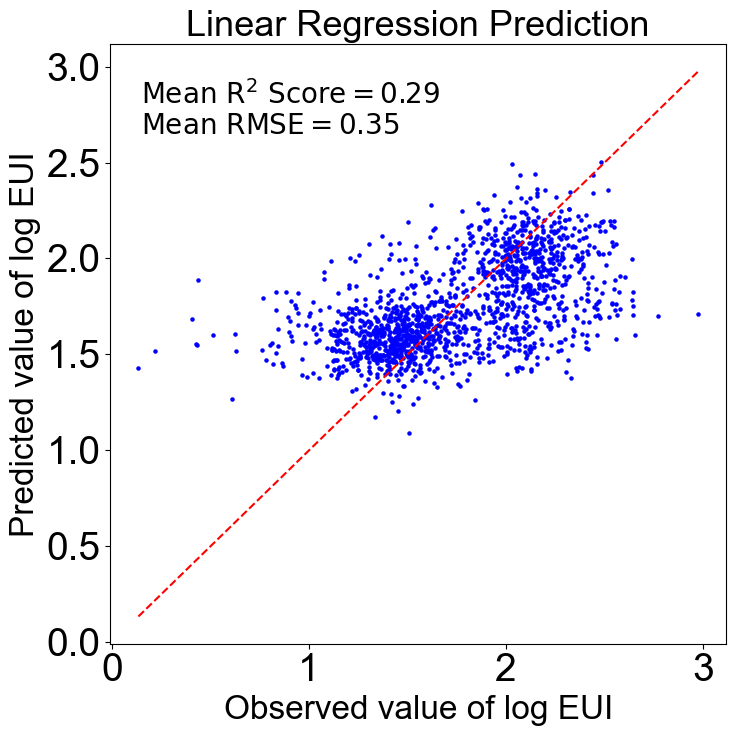

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Assuming you have your input features stored in the 'X' DataFrame and labels in the 'log_eui' variable as a NumPy array

regressor = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

r2_scores = []
rmse_scores = []

X_reset = X.reset_index(drop=True)  # Reset the index of X
log_eui_reset = pd.Series(log_eui).reset_index(drop=True)  # Reset the index of log_eui

for (train, test), i in zip(cv.split(X_reset, log_eui_reset), range(5)):
    regressor.fit(X_reset.iloc[train], log_eui_reset[train])
    y_pred = regressor.predict(X_reset.iloc[test])
    r2 = metrics.r2_score(log_eui_reset[test], y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(log_eui_reset[test], y_pred))
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    print("--------------------------------- Linear Regression Result ----------------------------------------")
    print("R-squared:", r2)
    print("RMSE:", rmse)

# Set the font to Arial
font_path = r"C:\Users\jhcwgtang\Downloads\Arial.ttf"  # Path to Arial font file
font_prop = font_manager.FontProperties(fname=font_path)

# Set the font properties for the plot
plt.rcParams['font.family'] = font_prop.get_name()

# Create a scatter plot of the mean predicted values versus the actual values
plt.figure(figsize=(8, 8))
plt.scatter(log_eui, regressor.predict(X_reset), color='b', alpha=1, s=5, label='Data')
plt.plot([min(log_eui), max(log_eui)], [min(log_eui), max(log_eui)], 'r--')
plt.xlabel('Observed value of log EUI', fontproperties=font_prop, fontsize=24)
plt.ylabel('Predicted value of log EUI', fontproperties=font_prop, fontsize=24)
plt.title('Linear Regression Prediction', fontproperties=font_prop,fontsize=26)

# Add text labels for R2 score and RMSE
textstr = '\n'.join((
    r'$\mathrm{Mean\ R^2\ Score}=%.2f$' % (np.mean(r2_scores),),
    r'$\mathrm{Mean\ RMSE}=%.2f$' % (np.mean(rmse_scores),)))
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,
         fontsize=20, verticalalignment='baseline')

plt.tight_layout()
plt.show()

In [ ]:
# Shapley Value
import shap
import sklearn
from sklearn.ensemble import RandomForestRegressor

explainer = shap.TreeExplainer(rf, X, model_output='probability')
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[0], X)

plt.show()

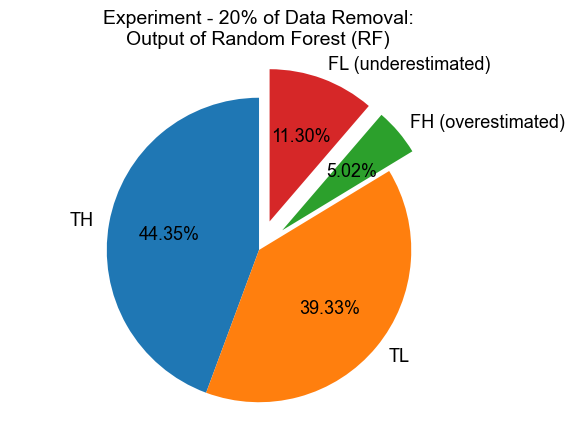

<Figure size 1920x1440 with 0 Axes>

In [46]:
plt.rcParams["font.family"] = "arial"
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [106, 94, 12, 27]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of Random Forest (RF)",fontsize = 14)
ax1.axis('equal') 
plt.figure(dpi=300)
plt.show()

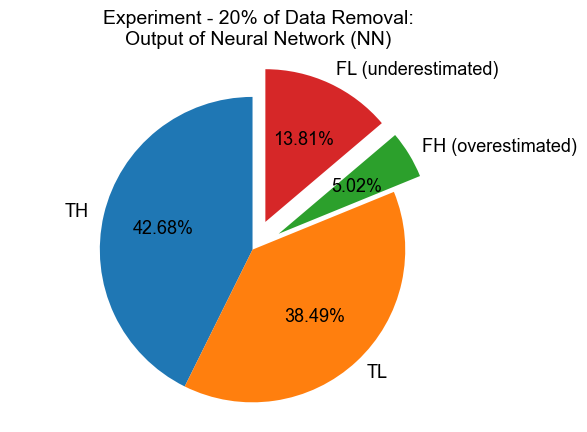

<Figure size 1920x1440 with 0 Axes>

In [47]:
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [102, 92, 12, 33]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of Neural Network (NN)",fontsize = 14)
plt.figure(dpi=300)
ax1.axis('equal') 
plt.show()

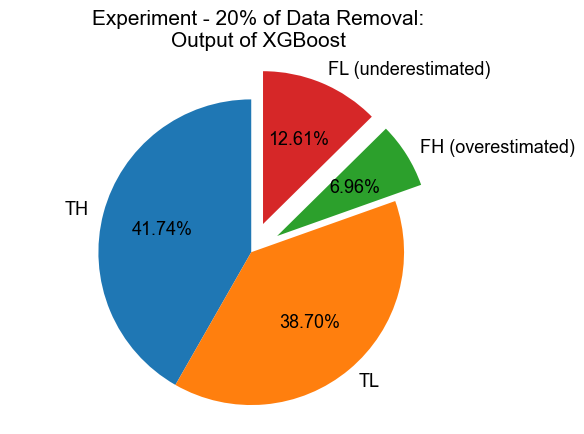

<Figure size 1920x1440 with 0 Axes>

In [48]:
plt.rcParams["font.family"] = "arial"
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [96, 89, 16, 29]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of XGBoost",fontsize = 15)
plt.figure(dpi=300)
ax1.axis('equal') 
plt.show()

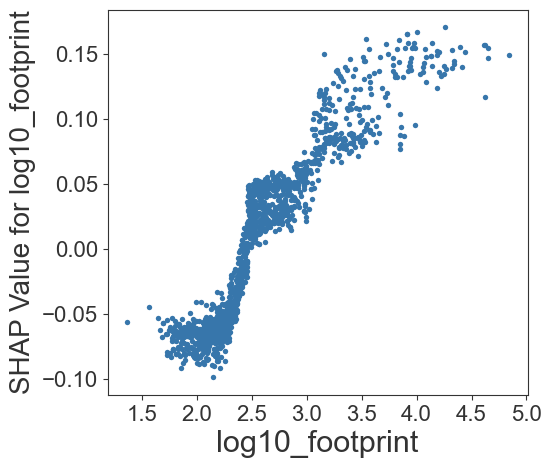

In [434]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["text.color"] = "black"
shap.dependence_plot("log10_footprint", shap_values[0], X,  interaction_index=None, show=False, color="#3776ab", ax=None, dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('log10_footprint',fontsize=22)
plt.ylabel('SHAP Value for log10_footprint',fontsize=20)
plt.savefig('log10_footprint.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

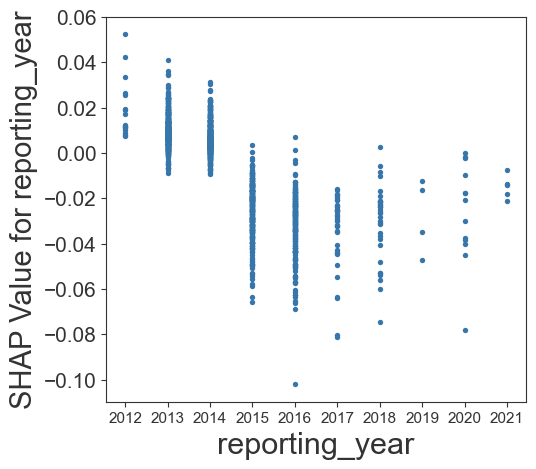

In [494]:
shap.dependence_plot("reporting_year", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [1,2,3,4,5,6,7,8,9,10]
label = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
plt.xticks(x,label, fontsize=11)
plt.yticks(fontsize=15)
plt.xlabel('reporting_year',fontsize=22)
plt.ylabel('SHAP Value for reporting_year',fontsize=21)
plt.savefig('reporting_year.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

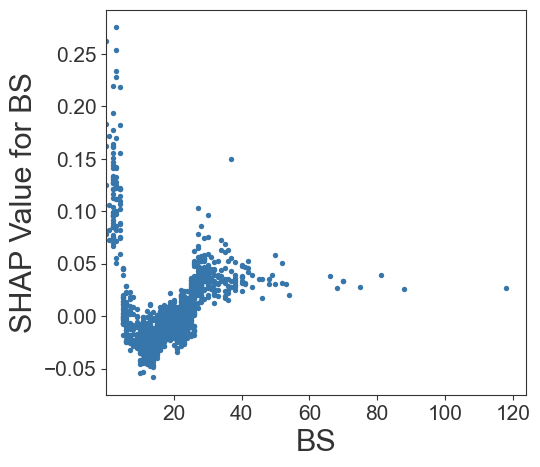

In [495]:
shap.dependence_plot("BS", shap_values[0], X, xmin=0.01, interaction_index=None, show=False, color="#3776ab", dot_size=15)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('BS',fontsize=22)
plt.ylabel('SHAP Value for BS',fontsize=22)
plt.savefig('BS.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

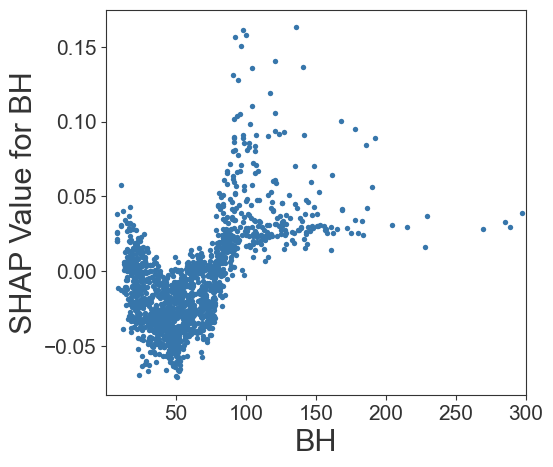

In [496]:
shap.dependence_plot("BH", shap_values[0], X, xmin=0.01, xmax = 300, interaction_index=None, show=False, color="#3776ab", dot_size=15)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('BH',fontsize=22)
plt.ylabel('SHAP Value for BH',fontsize=22)
plt.savefig('BH.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

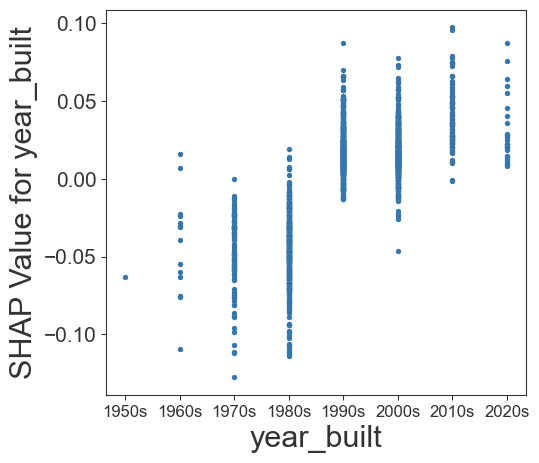

In [497]:
shap.dependence_plot("year_built", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)

plt.rcParams["font.family"] = "arial"
plt.subplots_adjust(left=0.2,right=0.9)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [1,2,3,4,5,6,7,8]
label = ['1950s','1960s','1970s','1980s','1990s','2000s','2010s','2020s']
plt.xticks(x,label, fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('year_built',fontsize=22)
plt.ylabel('SHAP Value for year_built',fontsize=22)
plt.savefig('year_built.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

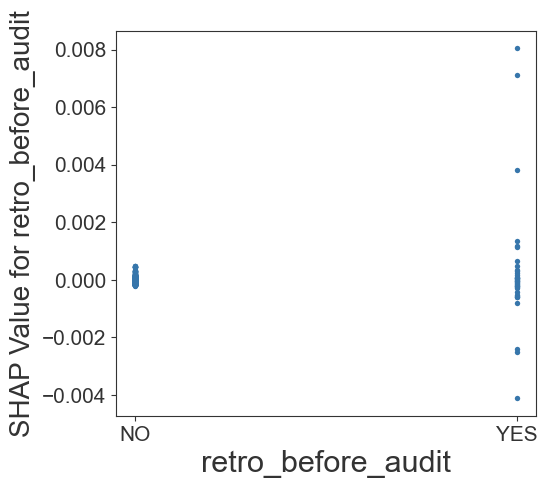

In [498]:
shap.dependence_plot("retro_before_audit", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_before_audit',fontsize=22)
plt.ylabel('SHAP Value for retro_before_audit',fontsize=20)
plt.savefig('retro_before_audit.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

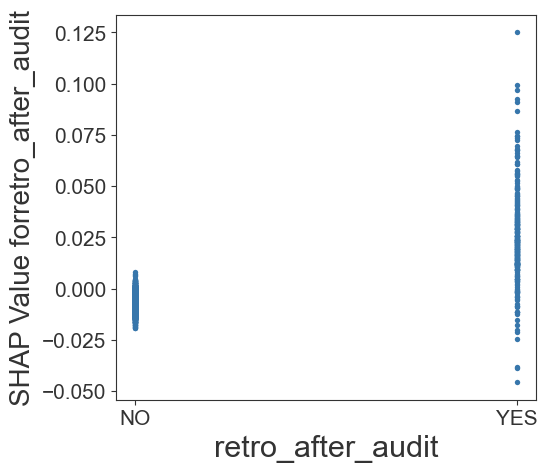

In [499]:
shap.dependence_plot("retro_after_audit", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_after_audit',fontsize=22)
plt.ylabel('SHAP Value forretro_after_audit',fontsize=20)
plt.savefig('retro_after_audit.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

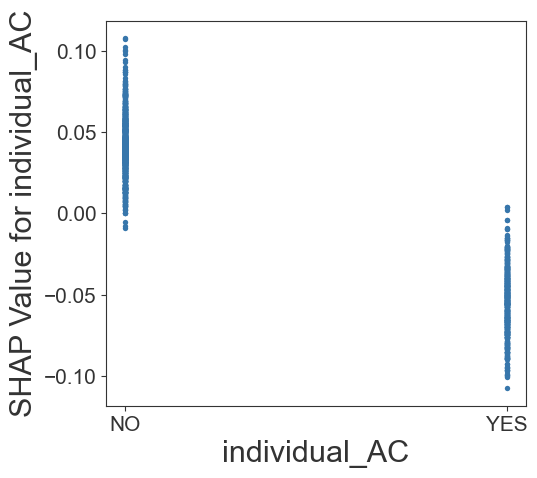

In [500]:
shap.dependence_plot("individual_AC", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('individual_AC',fontsize=22)
plt.ylabel('SHAP Value for individual_AC',fontsize=22)
plt.savefig('individual_AC.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

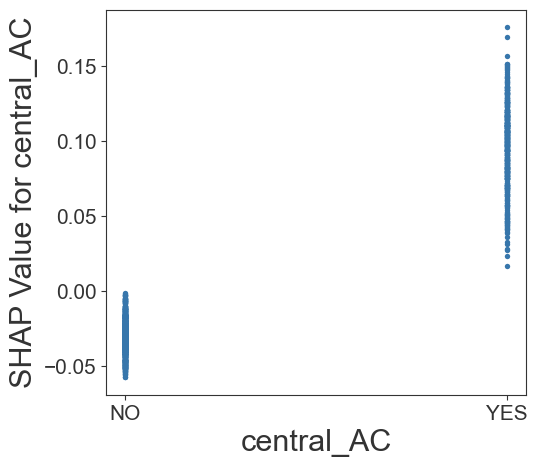

In [501]:
shap.dependence_plot("central_AC", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('central_AC',fontsize=22)
plt.ylabel('SHAP Value for central_AC',fontsize=22)
plt.savefig('central_AC.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

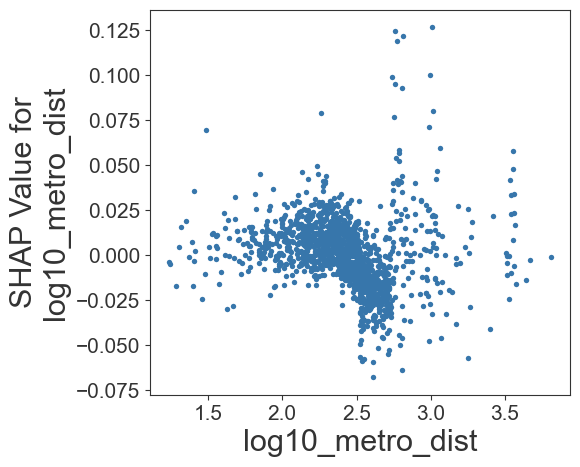

In [502]:
shap.dependence_plot("log10_metro_dist", shap_values[0], X , interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_metro_dist',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_metro_dist',fontsize=22)
plt.savefig('log10_metro_dist.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

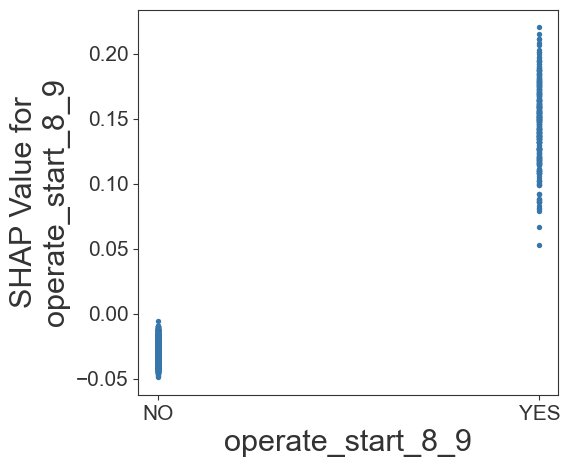

In [503]:
shap.dependence_plot("operate_start_8_9", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('operate_start_8_9',fontsize=22)
plt.ylabel('SHAP Value for\noperate_start_8_9',fontsize=22)
plt.savefig('operate_start_8-9am.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

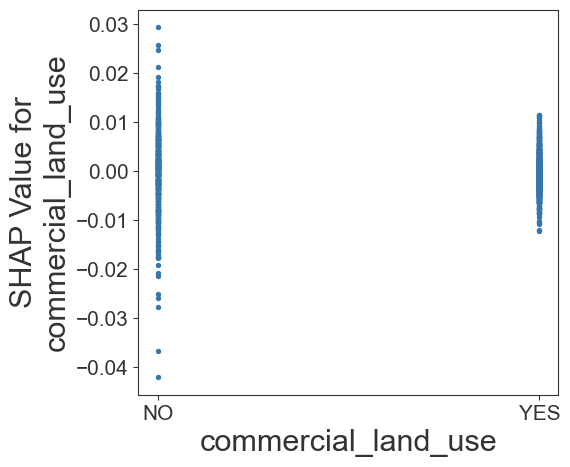

In [504]:
shap.dependence_plot("commercial_land_use", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('commercial_land_use',fontsize=22)
plt.ylabel('SHAP Value for\ncommercial_land_use',fontsize=22)
plt.savefig('commercial_land_use.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

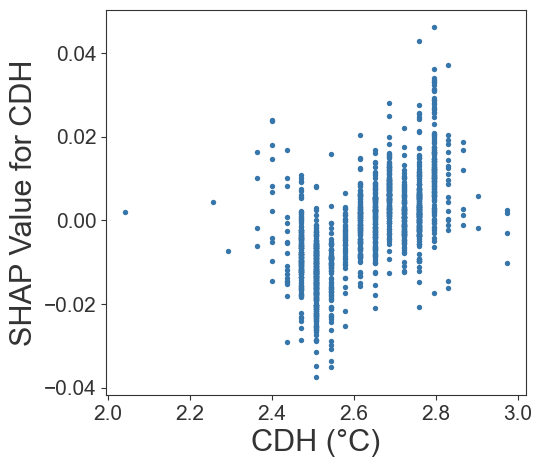

In [505]:
shap.dependence_plot("CDH", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('CDH (°C)',fontsize=22)
plt.ylabel('SHAP Value for CDH',fontsize=22)
plt.savefig('CDH(°C).png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

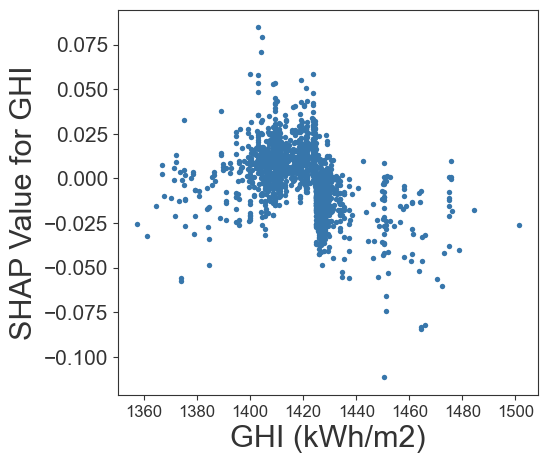

In [506]:
shap.dependence_plot("GHI", shap_values[0], X, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xticks(fontsize=12)
plt.xlabel('GHI (kWh/m2)',fontsize=22)
plt.ylabel('SHAP Value for GHI',fontsize=22)
plt.savefig('GHI.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

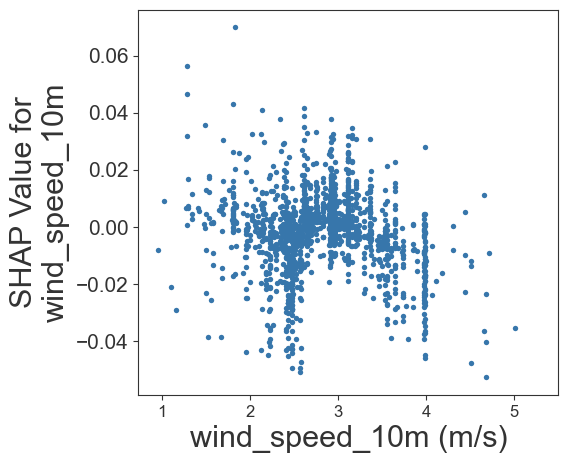

In [507]:
shap.dependence_plot("wind_speed_10m", shap_values[0], X, xmax =5.5, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xticks(fontsize=12)
plt.xlabel('wind_speed_10m (m/s)',fontsize=22)
plt.ylabel('SHAP Value for\nwind_speed_10m',fontsize=22)
plt.savefig('wind_speed.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

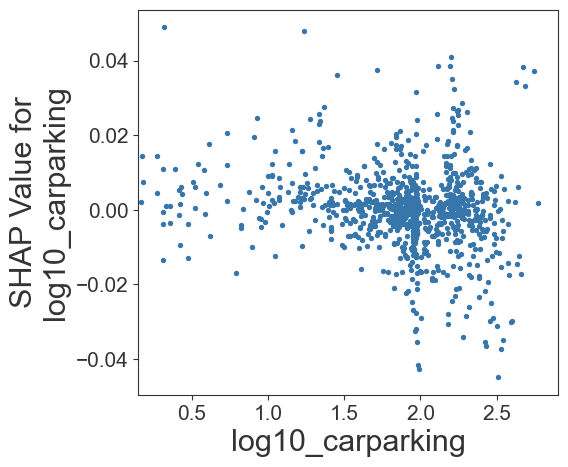

In [508]:
shap.dependence_plot("log10_carparking", shap_values[0], X, xmin=0.15, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_carparking',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_carparking',fontsize=22)
plt.savefig('log10_carparking.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

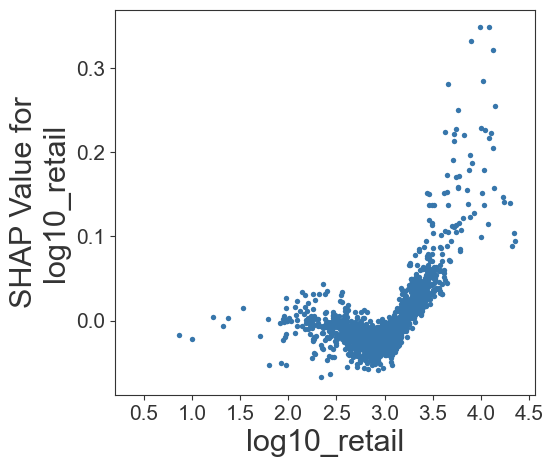

In [509]:
shap.dependence_plot("log10_retail", shap_values[0], X, xmin=0.2, interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_retail',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_retail',fontsize=22)
plt.savefig('log10_retail.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

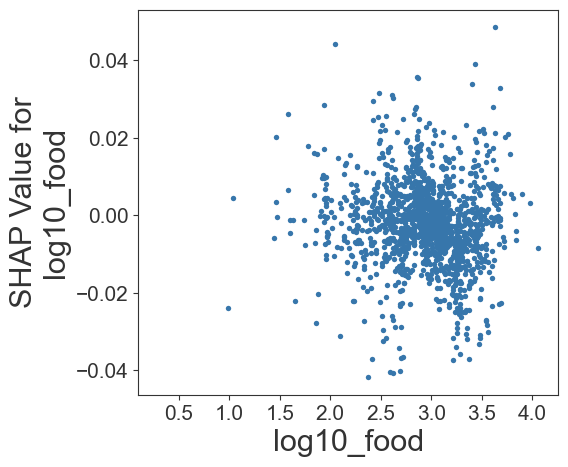

In [510]:
shap.dependence_plot("log10_food", shap_values[0], X, xmin=0.1, interaction_index=None, show=False, ax=None,color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_food',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_food',fontsize=22)
plt.savefig('log10_food.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

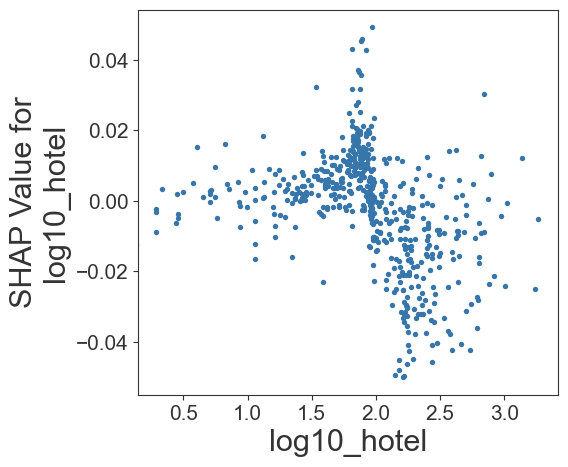

In [511]:
shap.dependence_plot("log10_hotel", shap_values[0], X, interaction_index=None, xmin = 0.15, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_hotel',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_hotel',fontsize=22)
plt.savefig('log10_hotel.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()

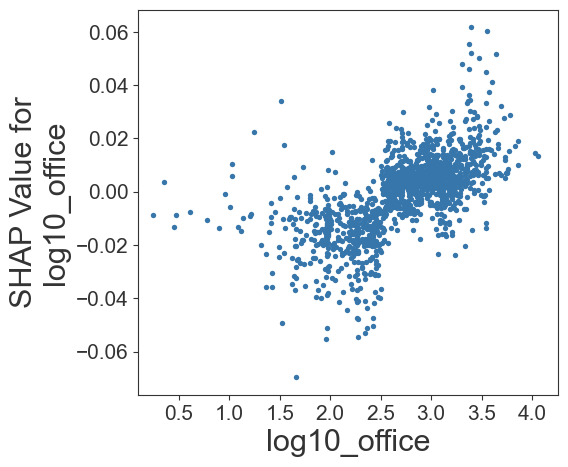

In [512]:
shap.dependence_plot("log10_office", shap_values[0], X,  xmin = 0.1,interaction_index=None, show=False, ax=None, color="#3776ab", dot_size=15)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_office',fontsize=22)
plt.ylabel('SHAP Value for\nlog10_office',fontsize=22)
plt.savefig('log10_office.png', dpi=300, bbox_inches = 'tight') # Save the plot as a PNG file with 300dpi resolution
plt.show()